`/interactive-runner`

In [1]:
!rm -rf /kaggle/working/data
!rm /kaggle/working/data.zip
!rm results.csv
!rm -rf /kaggle/working/artefacts

rm: cannot remove '/kaggle/working/data.zip': No such file or directory
rm: cannot remove 'results.csv': No such file or directory


In [1]:
!pip install gdown
#import gdown
#from cld_data_processing import download_data

`/model/util.py`

In [2]:
"""
Functions for creating and training models, used across the various tasks.
"""
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.data import Dataset
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D
from typing import NamedTuple, Tuple


class Params(NamedTuple):
    """
    Job Parameters Struct
    """
    image_size: int
    batch_size: int
    epochs: int
    epsilon: float
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool


@dataclass
class ModelWrapper():
    """
    Util class to hold the "outer" model, and the inner base model
    so that training can be fine-tuned if required.
    """    
    model: keras.Model
    base_model: keras.Model

        
def create_convnext_base(params: Params) -> ModelWrapper:
    return create_model(tf.keras.applications.ConvNeXtBase, "baseline", DEFAULT_PARAMS)


def create_model(base_model_fn: str, name: str, params: Params) -> ModelWrapper:
    """
    Create Keras application model, e.g.
        tf.keras.applications.EfficientNetV2B0
        tf.keras.applications.ConvNeXtBase
    with a custom top.
    """
    # i = 0
    # name=f"{name}-{(i:=i+1)}"
    # name = [name+str(i) for i in range(17)]
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    # Base
    base_model = base_model_fn(weights='imagenet', include_top=False)
    base_model.trainable = False
    # set training=F here per https://keras.io/guides/transfer_learning/
    x = base_model(inputs, training=False)
    # Head
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1024, activation="gelu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="gelu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    return ModelWrapper(model, base_model)


def create_model_ablations(base_model_fn: str, name: str, params: Params, fc_layers = 2, fc_neurons = 1024) -> ModelWrapper:
    """
    Create Keras application model, e.g.
        tf.keras.applications.EfficientNetV2B0
        tf.keras.applications.ConvNeXtBase
    with a custom top.
    """
    # i = 0
    # name=f"{name}-{(i:=i+1)}"
    # name = [name+str(i) for i in range(17)]
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    # Base
    base_model = base_model_fn(weights='imagenet', include_top=False)
    base_model.trainable = False
    # set training=F here per https://keras.io/guides/transfer_learning/
    x = base_model(inputs, training=False)
    # Head
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    
    l = 0
    while (l < fc_layers):
        x = Dense(fc_neurons, activation="relu")(x)
        x = Dropout(0.5)(x)
        l = l + 1
    
    outputs = Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    return ModelWrapper(model, base_model)


def run_task(task_id: str, model_wrapper: ModelWrapper,
             ds_train: Dataset, ds_valid: Dataset, ds_test: Dataset,
             params: Params, weights = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    model = model_wrapper.model
    # train
    df_train = train(task_id, model, ds_train, ds_valid, params)
    # test
    test_result = model.evaluate(ds_test)
    df_test = create_test_record(task_id, test_result)
    # save CM too
    save_confusion_matrix(ds_test, model, task_id)
    return df_train, df_test


def train(task_id: str, model: Model,
             ds_train_: Dataset, ds_valid_: Dataset,
             params: Params, weights = None) -> pd.DataFrame:
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=params.epsilon),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.0005, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
   
    df_hist = pd.DataFrame(history.history)
    df_hist["task_id"] = task_id
    df_hist["epoch"] = df_hist.index
   
    return df_hist


def create_test_record(task_id: str, result: list[float]):
    return pd.DataFrame({"task_id": [task_id], "test_loss" : [result[0]], "test_accuracy": [result[1]]})


def save_confusion_matrix(ds: Dataset, model: Model, task_id: str) -> None:
    path = f"artefacts/conf_mat_{task_id}.png"
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    disp.ax_.set_title(task_id)
    
    print(f"Saving confusion matrix to {path}")
    disp.figure_.savefig(f"artefacts/conf_mat_{task_id}.png", dpi=300)
    
    
def create_vgg_like_model(params: Params) -> ModelWrapper:
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    # classification layers
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    return ModelWrapper(model, None)



def create_simple_model(params: Params) -> Model:
    m = keras.Sequential([
        
        tf.keras.Input(shape=(params.image_size, params.image_size, 3)),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])
    return ModelWrapper(m, None)

`/data/data_processing.py`

In [3]:
import gdown
import keras
import pandas as pd
import random
import shutil
import tensorflow as tf
import os
import zipfile

# handle different dir structure kaggle vs colab
try:
    from AMLS_II_assignment23_24.model.util import Params
except ModuleNotFoundError:
    pass

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from typing import Tuple


def data_preprocessing(path: Path,
                       params: Params,
                       force=False) -> Tuple[Dataset, Dataset, Dataset, dict]:
    """
    """
    file = download_data(path, force)
    
    data_path = path / "data"
    if force:
        shutil.rmtree(data_path)
        
    if not data_path.exists():
        data_path.mkdir(parents=True, exist_ok=True)
       
        with zipfile.ZipFile(file, "r") as z:
            z.extractall(data_path)
        
    df_images = pd.read_csv((data_path / "train.csv"))
    
#     imgs1 = random.sample(df_images[df_images.label==3].image_id.tolist(), k=6579)
#     imgs2 = df_images[df_images.label!=3].image_id.tolist()
    
#     df_images = df_images[df_images.image_id.isin((imgs1+imgs2))].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(df_images.image_id, df_images.label, test_size=0.2, random_state=12)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12)
    
    train_path = create_ds_tree(X_train, y_train, data_path, "train")
    valid_path = create_ds_tree(X_valid, y_valid, data_path, "valid")
    test_path = create_ds_tree(X_test, y_test, data_path, "test")
    
    ds_train = create_dataset(train_path, params.image_size, params.batch_size)
    ds_valid = create_dataset(valid_path, params.image_size, params.batch_size)
    ds_test = create_dataset(test_path, params.image_size, params.batch_size, False)

    return ds_train, ds_valid, ds_test, extract_class_weights(df_images)


def download_data(path: Path, force=False) -> Path:
    """
    """
    url = "https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT"
    output = path / "data.zip"
    if not Path(output).exists() or force:
        gdown.download(url, str(output), quiet=False)
    return output


def create_ds_tree(x, y, path: Path, name: str) -> Path:
    """
    Creates the directory structure for the given dataset.
    """
    ds_path = path / name
    if not ds_path.exists():
        ds_path.mkdir(parents=True, exist_ok=True)

        for lab in y.unique():
            (ds_path / str(lab)).mkdir(exist_ok=True)

        source_path = path / "train_images"
        
        for img, lab in zip(x, y):
            src = source_path / img
            dest = ds_path / str(lab) / img
            shutil.move(src, dest)
        
    return ds_path


def create_dataset(path: Path, img_size: int, batch_size: int, shuffle = True) -> Dataset:
    """
    """
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[img_size, img_size],
        batch_size=batch_size,
        seed=12345,
        shuffle=shuffle,
        crop_to_aspect_ratio=True
    )


def extract_class_weights(df_data: pd.DataFrame) -> dict:
    classes = df_data.label.unique()
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=classes,
                                         y=df_data.label)

    return dict(zip(classes, class_weights))


def convert_dataset(ds: Dataset) -> Dataset:
    """
    """
    def convert_to_float(image, label):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = image / 255.0
        return image, label

    return (
        ds
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    

def augment_dataset(ds: Dataset, num_repeats: int) -> Dataset:
    """
    """
    def augment(image, label):
        seed = 12345
        image = tf.image.random_flip_left_right(image, seed)
        image = tf.image.random_flip_up_down(image, seed)
        image = tf.image.random_brightness(image, 0.2, seed)
        return image, label

    return (
        ds
        .repeat(num_repeats)
        .map(augment)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )

In [4]:
class ResultCollector():
    
    def __init__(
        self,
        path: Path
    ):
        self.path = path
        self.train_details = pd.DataFrame
        self.test_scores = pd.DataFrame

    def add_task_results(self, df_train, df_test) -> None:
        self.add_train_details(df_train)
        self.add_test_scores(df_test)
        
    def add_train_details(self, df: pd.DataFrame) -> None:
        if self.train_details.empty:
            self.train_details = df
        else:
            self.train_details = pd.concat([self.train_details, df])
        
        self._save(self.train_details, "train_details.csv")
        

    def get_train_details(self) -> pd.DataFrame:
        return self.train_details
    
    def add_test_scores(self, df: pd.DataFrame) -> None:
        if self.test_scores.empty:
            self.test_scores = df
        else:
            self.test_scores = pd.concat([self.test_scores, df])
            
        self._save(self.test_scores, "test_scores.csv")
            
    def get_test_scores(self) -> pd.DataFrame:
        return self.test_scores
    
    def _save(self, df: pd.DataFrame, name: str) -> None:
        df.to_csv(self.path / name, index=False)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_experiments_comp2(df_history: pd.DataFrame, task_ids: list, epoch_limit = 50) -> None:
    df = df_history[(df_history.task_id.isin(task_ids)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","task_id", "val_accuracy", "val_loss", "loss_gap"]].groupby(["epoch", "task_id"]).mean()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))
    sns.lineplot(data=df_grp, x="epoch", y="val_accuracy", hue="task_id",  ax=ax1)
    sns.lineplot(data=df_grp, x="epoch", y="val_loss", hue="task_id",  ax=ax2)
    sns.lineplot(data=df_grp, x="epoch", y="loss_gap", hue="task_id",  ax=ax3)

`main.py`

In [6]:
import datetime
import os
import pandas as pd
import tensorflow as tf

# handle different dir structure kaggle vs colab
try:
    from AMLS_II_assignment23_24.data_processing import pre_processing as data
    from AMLS_II_assignment23_24.model import util as model_util
    from AMLS_II_assignment23_24.model.util import Params, ResultCollector
except ModuleNotFoundError:
    pass

from docopt import docopt
from pathlib import Path

tf.random.set_seed(67890)

DEFAULT_PARAMS = Params(255, 196, 50, 0.005, True, 5, False)
## DEFAULT_PARAMS = model_util.Params(50, 196, 1, True, 5, False)
#DEFAULT_PARAMS = Params(50, 196, 1, 0.005, True, 5, False)
print(DEFAULT_PARAMS)

ARTEFACTS_PATH = Path("artefacts")
ARTEFACTS_PATH.mkdir(parents=True, exist_ok=True)

collector = ResultCollector(ARTEFACTS_PATH)

# Process Data
print("==== Loading Data ====")
cwd = os.getcwd()
# ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), DEFAULT_PARAMS)
# print(f"Class Weights: {class_weights}")

# print("==== Task A: Baseline Model ====")

# model = create_convnext_base(DEFAULT_PARAMS)
# df_train, df_test = run_task("A_base", model, ds_train, ds_valid, ds_test, DEFAULT_PARAMS)
# collector.add_task_results(df_train, df_test)

# print("==== Task B: Baseline + Data Augmentation ====")
# {
#     """
#     Per task A, but with data augmentation.
#     """
#     ds_train_aug = augment_dataset(ds_train, 2)
#     model = create_convnext_base(DEFAULT_PARAMS)
#     df_train, df_test = run_task("B_base_aug", model, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
#     collector.add_task_results(df_train, df_test)    
# }

# print("==== Task C: Baseline + Data Augmentation + Class Weights ====")
# model = create_convnext_base(DEFAULT_PARAMS)
# {
#     """
#     Per task B but, given the large class imbalance, class weight supplied.
#     """
#     ds_train_aug = augment_dataset(ds_train, 2)
#     df_train, df_test = run_task("C_base_aug_wgts", model, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
#     collector.add_task_results(df_train, df_test)    
# }

# print("==== Task D: Baseline + Data Augmentation + Class Weights + Fine Tune ====")
# {
#     """
#     Per task C but, given the large class imbalance, class weight supplied.
#     """
#     fine_tune_params = Params(50, 196, 1, 1e-5, True, 5, False)
#     print(fine_tune_params)
#     model.base_model.trainable = True
#     ds_train_aug = augment_dataset(ds_train, 2)
#     df_train, df_test = run_task("D_base_aug_wgts_ft", model, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
#     collector.add_task_results(df_train, df_test)    
# }


Params(image_size=255, batch_size=196, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
==== Loading Data ====


In [ ]:
model.model.save("/kaggle/working/artefacts/model_a.keras")

Batch Size: 64
Start: 2024-03-29 16:53:41.291004
Params(image_size=255, batch_size=64, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50
  1/201 ━━━━━━━━━━━━━━━━━━━━ 54:31 16s/step - accuracy: 0.1562 - loss: 1.8721

W0000 00:00:1711731240.154413     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.154843     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.155301     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.156283     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.156658     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.157027     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.157398     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.157755     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6062 - loss: 1.1075

W0000 00:00:1711731281.371245     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.371648     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.372095     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.373037     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.373400     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.373723     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.374043     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.374376     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


201/201 ━━━━━━━━━━━━━━━━━━━━ 76s 296ms/step - accuracy: 0.6065 - loss: 1.1068 - val_accuracy: 0.7194 - val_loss: 0.7501
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 240ms/step - accuracy: 0.6972 - loss: 0.8144 - val_accuracy: 0.7369 - val_loss: 0.7037
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.7191 - loss: 0.7547 - val_accuracy: 0.7502 - val_loss: 0.6791
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - accuracy: 0.7312 - loss: 0.7239 - val_accuracy: 0.7544 - val_loss: 0.6747
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 240ms/step - accuracy: 0.7417 - loss: 0.6894 - val_accuracy: 0.7577 - val_loss: 0.6509
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - accuracy: 0.7500 - loss: 0.6780 - val_accuracy: 0.7626 - val_loss: 0.6442
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - accuracy: 0.7593 - loss: 0.6457 - val_accuracy: 0.7579 - val_loss: 0.6468
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.7641 - loss: 0.6381 - val

W0000 00:00:1711732213.082649     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.083250     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.083638     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.084813     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.085241     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.085627     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.086029     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.086695     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step


W0000 00:00:1711732226.497978     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732226.498314     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732226.498765     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732226.501754     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732226.502110     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732226.502486     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_64.png
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.6777 - loss: 0.8326
[0.5994129180908203, 0.7782710194587708]
End: 2024-03-29 17:10:53.691764
Batch Size: 128
Start: 2024-03-29 17:10:53.691798
Params(image_size=255, batch_size=128, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50


W0000 00:00:1711732278.615678     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.615994     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.616467     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.616842     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.617181     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.617512     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.617826     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.618171     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5834 - loss: 1.1934

W0000 00:00:1711732318.503154     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.503540     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.503904     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.504851     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.505233     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.505602     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.505948     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.506320     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 589ms/step - accuracy: 0.5838 - loss: 1.1920 - val_accuracy: 0.6984 - val_loss: 0.7937
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 473ms/step - accuracy: 0.6794 - loss: 0.8663 - val_accuracy: 0.7229 - val_loss: 0.7343
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 472ms/step - accuracy: 0.7021 - loss: 0.7982 - val_accuracy: 0.7325 - val_loss: 0.7164
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy: 0.7171 - loss: 0.7630 - val_accuracy: 0.7430 - val_loss: 0.6962
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 475ms/step - accuracy: 0.7304 - loss: 0.7318 - val_accuracy: 0.7456 - val_loss: 0.6792
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 473ms/step - accuracy: 0.7274 - loss: 0.7244 - val_accuracy: 0.7563 - val_loss: 0.6650
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 472ms/step - accuracy: 0.7430 - loss: 0.6869 - val_accuracy: 0.7558 - val_loss: 0.6509
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 473ms/step - accuracy: 0.7456 - loss: 0.6796 - val

W0000 00:00:1711733683.452380     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.452710     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.453124     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.453535     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.453860     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.454191     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.454522     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.454838     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 400ms/step


W0000 00:00:1711733696.649533     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733696.649908     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733696.650233     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733696.653330     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733696.653672     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733696.654081     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_128.png
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.6644 - loss: 0.8585
[0.5908013582229614, 0.7869158983230591]
End: 2024-03-29 17:35:15.054516
Batch Size: 192
Start: 2024-03-29 17:35:15.054540
Params(image_size=255, batch_size=192, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5493 - loss: 1.2763

W0000 00:00:1711733794.699386     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733794.699825     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733794.700349     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.5502 - loss: 1.2739

W0000 00:00:1711733814.602308     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733814.602727     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733814.603206     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733814.606100     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733814.606399     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733814.606809     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5511 - loss: 1.2715 - val_accuracy: 0.6850 - val_loss: 0.8418
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 721ms/step - accuracy: 0.6635 - loss: 0.9159 - val_accuracy: 0.7058 - val_loss: 0.7599
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 714ms/step - accuracy: 0.6923 - loss: 0.8338 - val_accuracy: 0.7301 - val_loss: 0.7372
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 713ms/step - accuracy: 0.7020 - loss: 0.7904 - val_accuracy: 0.7346 - val_loss: 0.7118
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 714ms/step - accuracy: 0.7125 - loss: 0.7701 - val_accuracy: 0.7439 - val_loss: 0.7018
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 714ms/step - accuracy: 0.7245 - loss: 0.7396 - val_accuracy: 0.7516 - val_loss: 0.6833
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 719ms/step - accuracy: 0.7335 - loss: 0.7153 - val_accuracy: 0.7502 - val_loss: 0.6692
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 713ms/step - accuracy: 0.7341 - loss: 0.7203 - val_accuracy: 0.7547 -

W0000 00:00:1711735241.820450     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735241.820818     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735241.821251     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735241.824221     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735241.824552     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735241.824897     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_192.png
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - accuracy: 0.6802 - loss: 0.8117
[0.6071330904960632, 0.7801401615142822]
End: 2024-03-29 18:01:00.093955
Batch Size: 256
Start: 2024-03-29 18:01:00.093987
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.5589 - loss: 1.2615

W0000 00:00:1711735335.503937     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.504303     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.504734     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.505763     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.506164     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.506559     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.506931     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.507318     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.5597 - loss: 1.2592 - val_accuracy: 0.6626 - val_loss: 0.8757
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - accuracy: 0.6493 - loss: 0.9605 - val_accuracy: 0.7035 - val_loss: 0.7854
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 962ms/step - accuracy: 0.6819 - loss: 0.8691 - val_accuracy: 0.7157 - val_loss: 0.7487
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 948ms/step - accuracy: 0.6916 - loss: 0.8172 - val_accuracy: 0.7173 - val_loss: 0.7325
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 952ms/step - accuracy: 0.7035 - loss: 0.7914 - val_accuracy: 0.7357 - val_loss: 0.7098
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 950ms/step - accuracy: 0.7082 - loss: 0.7719 - val_accuracy: 0.7421 - val_loss: 0.6989
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 948ms/step - accuracy: 0.7217 - loss: 0.7500 - val_accuracy: 0.7453 - val_loss: 0.6884
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.7256 - loss: 0.7359 - val_accuracy: 0.7491 

W0000 00:00:1711737282.122741     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_256.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 660ms/step - accuracy: 0.6971 - loss: 0.8022
[0.5909342765808105, 0.7890186905860901]
End: 2024-03-29 18:35:01.277658


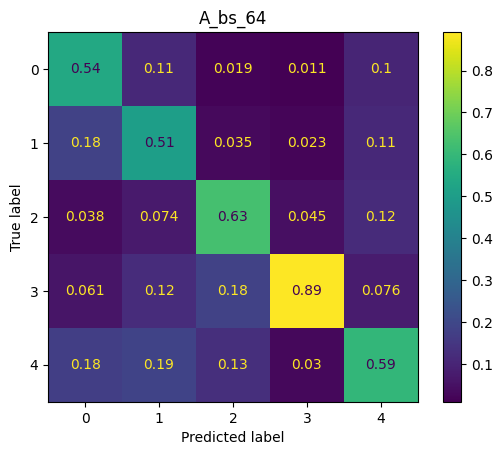

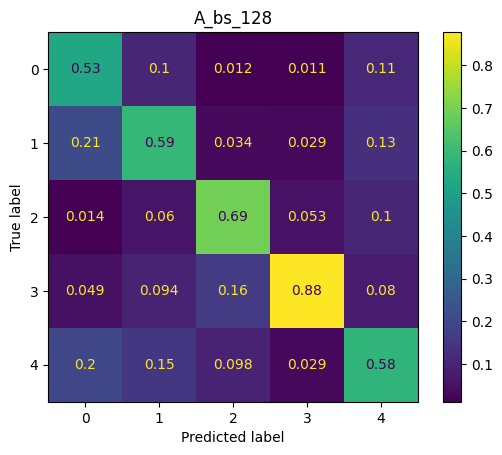

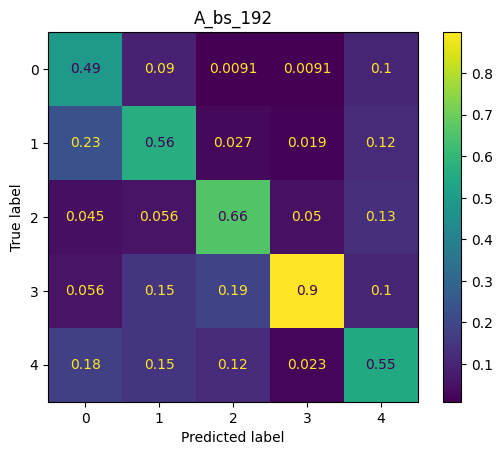

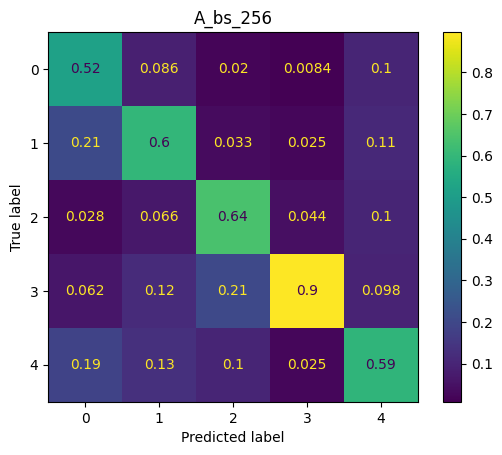

In [10]:
for bs in [64, 128, 192, 256]:
    print(f"Batch Size: {bs}")
    print(f"Start: {datetime.datetime.now()}")
    batch_size_params = Params(255, bs, 50, 0.005, True, 5, False)
    print(batch_size_params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), batch_size_params)
    model = create_model(tf.keras.applications.ConvNeXtTiny, "base", batch_size_params)
    df_train, df_test = run_task(f"A_bs_{bs}", model, ds_train, ds_valid, ds_test, batch_size_params)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")

In [ ]:
for bs in [512, 768, 1024]:
    print(f"Batch Size: {bs}")
    print(f"Start: {datetime.datetime.now()}")
    batch_size_params = Params(255, bs, 50, 0.005, True, 5, False)
    print(batch_size_params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), batch_size_params)
    model = create_model(tf.keras.applications.ConvNeXtTiny, "base", batch_size_params)
    df_train, df_test = run_task(f"A_bs_{bs}", model, ds_train, ds_valid, ds_test, batch_size_params)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")

Batch Size: 512
Start: 2024-03-29 18:42:36.250303
Params(image_size=255, batch_size=512, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50


2024-03-29 18:43:03.649784: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[512,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-29 18:43:03.788332: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.13872009s
Trying algorithm eng3{k11=2} for conv (f32[512,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
20

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5577 - loss: 1.3216

W0000 00:00:1711737848.462385     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.462740     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.463221     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.464330     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.464726     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.465192     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.465574     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.465922     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5589 - loss: 1.3180 - val_accuracy: 0.6336 - val_loss: 0.9756
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6211 - loss: 1.0592 - val_accuracy: 0.6792 - val_loss: 0.8657
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6496 - loss: 0.9627 - val_accuracy: 0.6956 - val_loss: 0.8216
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6625 - loss: 0.9087 - val_accuracy: 0.7054 - val_loss: 0.7777
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6768 - loss: 0.8644 - val_accuracy: 0.7159 - val_loss: 0.7631
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6835 - loss: 0.8395 - val_accuracy: 0.7215 - val_loss: 0.7464
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6946 - loss: 0.8256 - val_accuracy: 0.7280 - val_loss: 0.7368
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6995 - loss: 0.8038 - val_accuracy: 0.7346 - val_loss: 0.7295
Ep

W0000 00:00:1711740312.014277     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_512.png
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6842 - loss: 0.8174
[0.6394456028938293, 0.7757009267807007]
End: 2024-03-29 19:25:31.257298
Batch Size: 768
Start: 2024-03-29 19:25:31.257332
Params(image_size=255, batch_size=768, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50


2024-03-29 19:26:02.620306: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=4,k3=0} for conv (f32[768,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[768,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-29 19:26:02.681772: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.061645414s
Trying algorithm eng28{k2=4,k3=0} for conv (f32[768,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[768,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a 

16/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4681 - loss: 1.4286

2024-03-29 19:27:25.234848: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[549,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[549,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-29 19:27:25.485656: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.250973208s
Trying algorithm eng3{k11=2} for conv (f32[549,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[549,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4734 - loss: 1.4218

W0000 00:00:1711740485.892200     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711740523.143152     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.4781 - loss: 1.4158 - val_accuracy: 0.6343 - val_loss: 1.0505
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.5992 - loss: 1.1334 - val_accuracy: 0.6470 - val_loss: 0.9409
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6305 - loss: 1.0428 - val_accuracy: 0.6633 - val_loss: 0.8815
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6441 - loss: 0.9702 - val_accuracy: 0.6829 - val_loss: 0.8333
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.6603 - loss: 0.9196 - val_accuracy: 0.6944 - val_loss: 0.8072
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.6599 - loss: 0.8992 - val_accuracy: 0.7000 - val_loss: 0.7889
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.6710 - loss: 0.8767 - val_accuracy: 0.7063 - val_loss: 0.7687
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.6814 - loss: 0.8443 - val_accuracy: 0.7110 - val_loss: 0.7612
Ep

W0000 00:00:1711743567.095458     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


W0000 00:00:1711743578.901021     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_768.png
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7142 - loss: 0.7581
[0.6374288201332092, 0.7752336263656616]
End: 2024-03-29 20:19:59.096646
Batch Size: 1024
Start: 2024-03-29 20:19:59.096674
Params(image_size=255, batch_size=1024, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50


2024-03-29 20:20:35.342174: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=4,k3=0} for conv (f32[1024,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-29 20:20:35.757087: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.415001834s
Trying algorithm eng28{k2=4,k3=0} for conv (f32[1024,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is takin

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4103 - loss: 1.5381

W0000 00:00:1711743736.615706     128 hlo_rematerialization.cc:2946] Can't reduce memory use below 11.27GiB (12099020529 bytes) by rematerialization; only reduced to 13.08GiB (14046068812 bytes), down from 13.08GiB (14046068812 bytes) originally
W0000 00:00:1711743751.198812     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.4186 - loss: 1.5278 - val_accuracy: 0.6164 - val_loss: 1.1429
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.6028 - loss: 1.1922 - val_accuracy: 0.6283 - val_loss: 0.9680
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.6145 - loss: 1.0780 - val_accuracy: 0.6551 - val_loss: 0.9294
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.6351 - loss: 1.0072 - val_accuracy: 0.6619 - val_loss: 0.8586
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.6443 - loss: 0.9734 - val_accuracy: 0.6790 - val_loss: 0.8374
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.6458 - loss: 0.9475 - val_accuracy: 0.6921 - val_loss: 0.8138
Epoch 7/50
 3/13 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6598 - loss: 0.9080

In [13]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,A_bs_64,0.599413,0.778271
0,A_bs_128,0.590801,0.786916
0,A_bs_192,0.607133,0.780140
0,A_bs_256,0.590934,0.789019


In [2]:
import pandas as pd
df_res = pd.read_csv("/kaggle/working/artefacts/train_details.csv")

In [4]:
plot_experiments_comp2(collector.get_train_details(), collector.get_train_details().task_id.unique())

NameError: name 'collector' is not defined

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

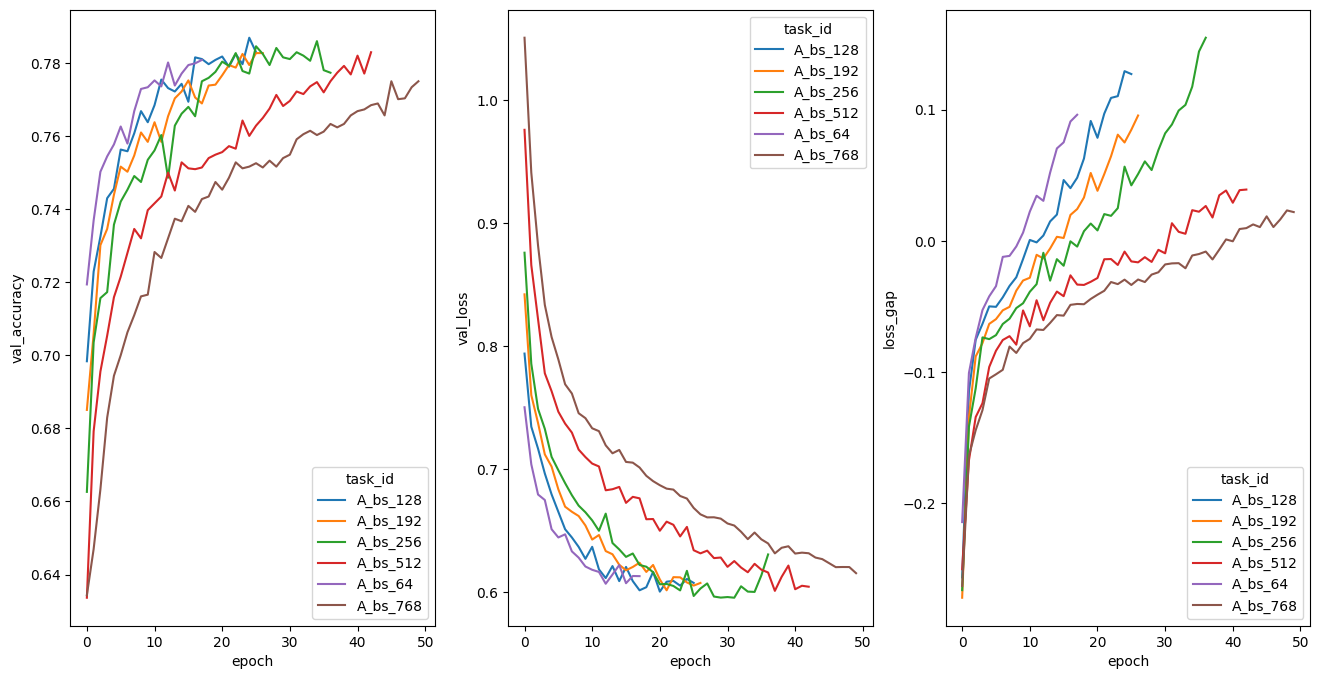

In [6]:
plot_experiments_comp2(df_res, df_res.task_id.unique())

Epsilon: 0.0025
Start: 2024-03-29 20:43:57.425413
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0025, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50


I0000 00:00:1711745083.631698    4874 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.5380 - loss: 1.2871

W0000 00:00:1711745126.416907    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.417332    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.417750    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.418795    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.419224    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.419641    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.420219    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.420646    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5392 - loss: 1.2836 - val_accuracy: 0.6925 - val_loss: 0.8257
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 956ms/step - accuracy: 0.6623 - loss: 0.8996 - val_accuracy: 0.7159 - val_loss: 0.7524
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 952ms/step - accuracy: 0.6886 - loss: 0.8176 - val_accuracy: 0.7290 - val_loss: 0.7313
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.7033 - loss: 0.7871 - val_accuracy: 0.7297 - val_loss: 0.7109
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 952ms/step - accuracy: 0.7166 - loss: 0.7588 - val_accuracy: 0.7502 - val_loss: 0.6880
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.7282 - loss: 0.7309 - val_accuracy: 0.7493 - val_loss: 0.6861
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.7323 - loss: 0.7195 - val_accuracy: 0.7519 - val_loss: 0.6655
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 959ms/step - accuracy: 0.7435 - loss: 0.6979 - val_accuracy: 0.7568 

W0000 00:00:1711746568.732706    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.733142    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.733608    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.734623    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.734987    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.735416    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.735808    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.736188    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5214 - loss: 1.3331 - val_accuracy: 0.6689 - val_loss: 0.8898
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 957ms/step - accuracy: 0.6485 - loss: 0.9613 - val_accuracy: 0.6995 - val_loss: 0.7909
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6807 - loss: 0.8548 - val_accuracy: 0.7159 - val_loss: 0.7553
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.6905 - loss: 0.8234 - val_accuracy: 0.7199 - val_loss: 0.7346
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 956ms/step - accuracy: 0.7033 - loss: 0.7987 - val_accuracy: 0.7322 - val_loss: 0.7148
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 957ms/step - accuracy: 0.7111 - loss: 0.7683 - val_accuracy: 0.7444 - val_loss: 0.7042
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 951ms/step - accuracy: 0.7136 - loss: 0.7614 - val_accuracy: 0.7428 - val_loss: 0.6933
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 954ms/step - accuracy: 0.7242 - loss: 0.7357 - val_accuracy: 0.7493 -

W0000 00:00:1711748566.601895    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.602275    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.602715    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.603722    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.604122    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.604509    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.604876    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.605242    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5200 - loss: 1.3344 - val_accuracy: 0.6568 - val_loss: 0.9028
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 948ms/step - accuracy: 0.6419 - loss: 0.9827 - val_accuracy: 0.6956 - val_loss: 0.8085
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6677 - loss: 0.8908 - val_accuracy: 0.7096 - val_loss: 0.7662
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.6786 - loss: 0.8482 - val_accuracy: 0.7150 - val_loss: 0.7478
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - accuracy: 0.6932 - loss: 0.8124 - val_accuracy: 0.7276 - val_loss: 0.7307
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 953ms/step - accuracy: 0.6996 - loss: 0.7987 - val_accuracy: 0.7369 - val_loss: 0.7167
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 947ms/step - accuracy: 0.7166 - loss: 0.7740 - val_accuracy: 0.7369 - val_loss: 0.7086
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 958ms/step - accuracy: 0.7154 - loss: 0.7571 - val_accuracy: 0.7414 -

W0000 00:00:1711751144.372594    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.372927    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.373433    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.374521    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.374970    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.375390    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.375804    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.376224    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4958 - loss: 1.3727 - val_accuracy: 0.6418 - val_loss: 0.9329
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 961ms/step - accuracy: 0.6351 - loss: 1.0062 - val_accuracy: 0.6841 - val_loss: 0.8326
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6620 - loss: 0.9094 - val_accuracy: 0.7012 - val_loss: 0.7856
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 949ms/step - accuracy: 0.6724 - loss: 0.8649 - val_accuracy: 0.7100 - val_loss: 0.7606
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6872 - loss: 0.8250 - val_accuracy: 0.7201 - val_loss: 0.7435
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6937 - loss: 0.8090 - val_accuracy: 0.7297 - val_loss: 0.7311
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 953ms/step - accuracy: 0.7068 - loss: 0.7831 - val_accuracy: 0.7313 - val_loss: 0.7210
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - accuracy: 0.7090 - loss: 0.7759 - val_accuracy: 0.7322 -

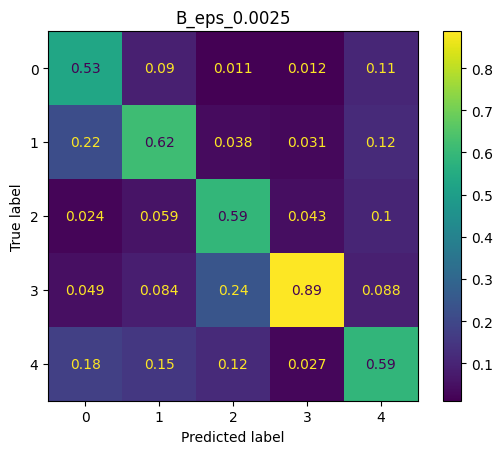

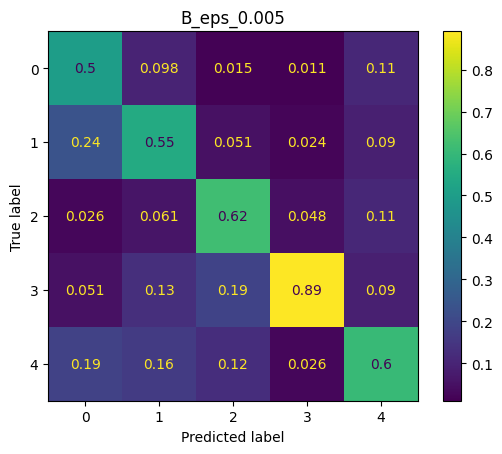

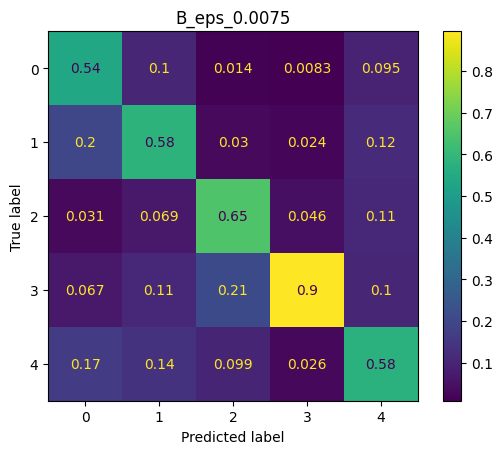

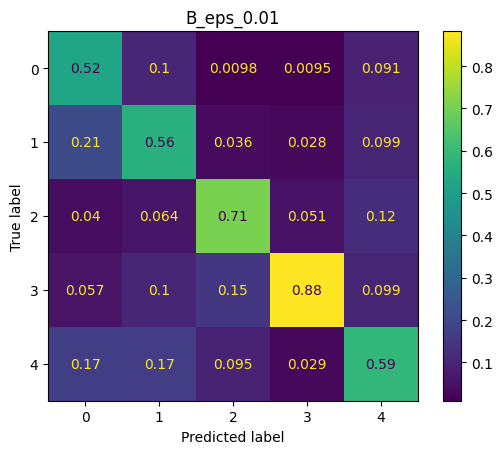

In [11]:
for eps in [0.0025, 0.0050, 0.0075, 0.01]:
    print(f"Epsilon: {eps}")
    print(f"Start: {datetime.datetime.now()}")
    params = Params(255, 256, 50, eps, True, 5, False)
    print(params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
    model = create_model(tf.keras.applications.ConvNeXtTiny, "base", params)
    df_train, df_test = run_task(f"B_eps_{eps}", model, ds_train, ds_valid, ds_test, params)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")

In [13]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,B_eps_0.0025,0.593052,0.782944
0,B_eps_0.005,0.590592,0.782009
0,B_eps_0.0075,0.584704,0.787150
0,B_eps_0.01,0.588137,0.786682


Epsilon: 0.006
Start: 2024-03-30 13:11:22.727252
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.006, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1711804327.738911     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.5205 - loss: 1.3330

W0000 00:00:1711804370.311051     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711804370.311417     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711804370.311931     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711804370.313015     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711804370.313376     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711804370.313728     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711804370.314055     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711804370.314375     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5218 - loss: 1.3299 - val_accuracy: 0.6668 - val_loss: 0.9003
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - accuracy: 0.6436 - loss: 0.9798 - val_accuracy: 0.6974 - val_loss: 0.8065
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 952ms/step - accuracy: 0.6721 - loss: 0.8809 - val_accuracy: 0.7129 - val_loss: 0.7648
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 958ms/step - accuracy: 0.6839 - loss: 0.8437 - val_accuracy: 0.7182 - val_loss: 0.7405
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 965ms/step - accuracy: 0.6953 - loss: 0.8066 - val_accuracy: 0.7318 - val_loss: 0.7216
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 956ms/step - accuracy: 0.7123 - loss: 0.7775 - val_accuracy: 0.7442 - val_loss: 0.7100
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 952ms/step - accuracy: 0.7162 - loss: 0.7684 - val_accuracy: 0.7409 - val_loss: 0.6983
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.7217 - loss: 0.7476 - val_accuracy: 0.7458 

W0000 00:00:1711806418.261324     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711806418.261834     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711806418.262261     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711806418.263357     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711806418.263821     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711806418.264200     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711806418.264584     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711806418.264978     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5401 - loss: 1.2987 - val_accuracy: 0.6619 - val_loss: 0.8986
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6440 - loss: 0.9871 - val_accuracy: 0.6965 - val_loss: 0.8077
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6742 - loss: 0.8825 - val_accuracy: 0.7136 - val_loss: 0.7644
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - accuracy: 0.6848 - loss: 0.8446 - val_accuracy: 0.7180 - val_loss: 0.7432
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6967 - loss: 0.8085 - val_accuracy: 0.7301 - val_loss: 0.7229
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - accuracy: 0.7014 - loss: 0.7886 - val_accuracy: 0.7404 - val_loss: 0.7147
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.7163 - loss: 0.7663 - val_accuracy: 0.7416 - val_loss: 0.7037
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 956ms/step - accuracy: 0.7180 - loss: 0.7527 - val_accuracy: 0.7456 -

W0000 00:00:1711808903.756019     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711808903.756436     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711808903.757015     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711808903.758096     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711808903.758462     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711808903.758847     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711808903.759219     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711808903.759587     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5160 - loss: 1.3473 - val_accuracy: 0.6582 - val_loss: 0.9183
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6394 - loss: 0.9939 - val_accuracy: 0.6937 - val_loss: 0.8204
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 951ms/step - accuracy: 0.6646 - loss: 0.8971 - val_accuracy: 0.7016 - val_loss: 0.7759
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 958ms/step - accuracy: 0.6772 - loss: 0.8603 - val_accuracy: 0.7110 - val_loss: 0.7547
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - accuracy: 0.6993 - loss: 0.8117 - val_accuracy: 0.7248 - val_loss: 0.7350
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 966ms/step - accuracy: 0.7003 - loss: 0.7946 - val_accuracy: 0.7287 - val_loss: 0.7224
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.7092 - loss: 0.7790 - val_accuracy: 0.7362 - val_loss: 0.7140
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 952ms/step - accuracy: 0.7156 - loss: 0.7661 - val_accuracy: 0.7388 -

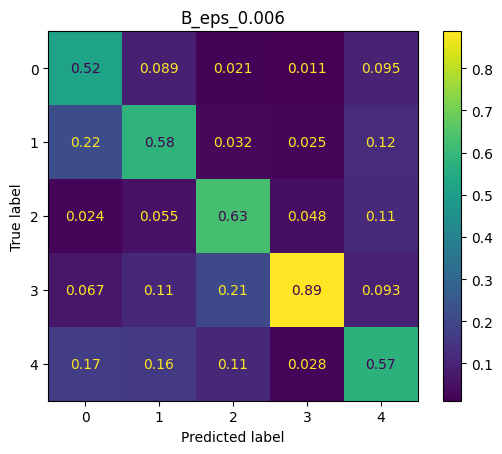

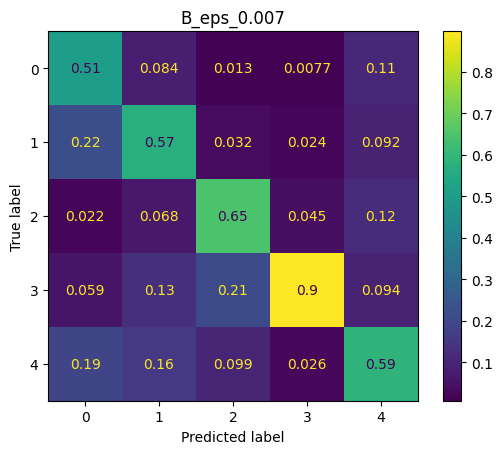

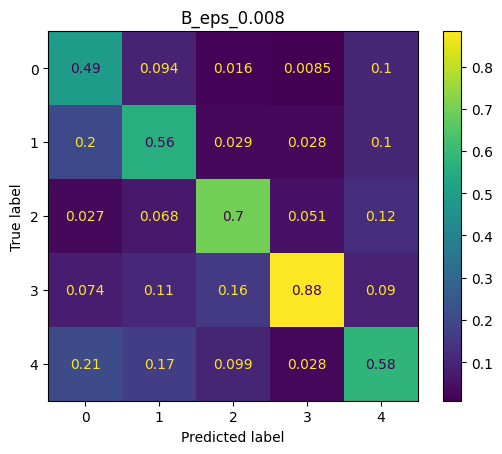

In [6]:
for eps in [0.006, 0.007, 0.008]:
    print(f"Epsilon: {eps}")
    print(f"Start: {datetime.datetime.now()}")
    params = Params(255, 256, 50, eps, True, 5, False)
    print(params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
    model = create_model(tf.keras.applications.ConvNeXtTiny, "base", params)
    df_train, df_test = run_task(f"B_eps_{eps}", model, ds_train, ds_valid, ds_test, params)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")

In [7]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,B_eps_0.006,0.591524,0.782243
0,B_eps_0.007,0.590308,0.785748
0,B_eps_0.008,0.591189,0.784112


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

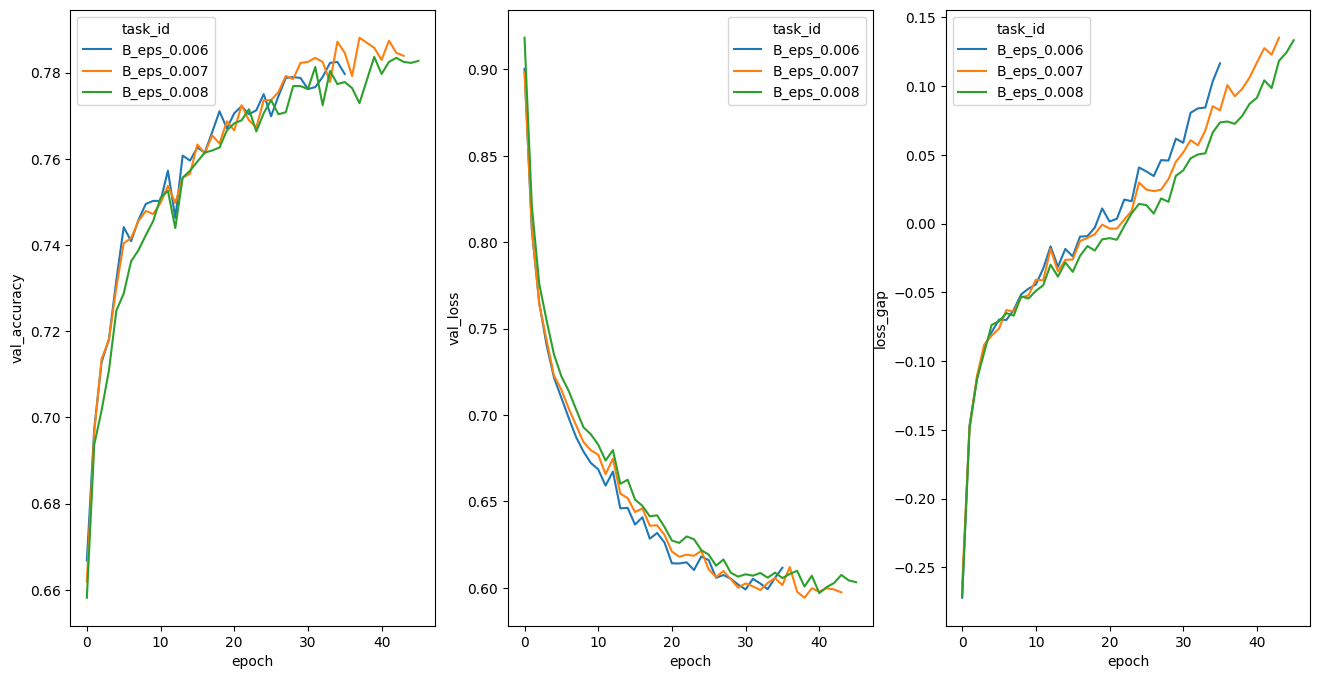

In [10]:
plot_experiments_comp2(collector.get_train_details(), collector.get_train_details().task_id.unique())

LR: True
Start: 2024-03-30 16:56:52.874820
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=True)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Using EarlyStopping
Using ReduceLROnPlateau
Epoch 1/50


I0000 00:00:1711817858.189146     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.4676 - loss: 1.4511

W0000 00:00:1711817899.668308     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711817899.668755     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711817899.669156     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711817899.672098     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711817899.672444     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711817899.672950     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.4696 - loss: 1.4467 - val_accuracy: 0.6393 - val_loss: 0.9352 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 957ms/step - accuracy: 0.6346 - loss: 1.0048 - val_accuracy: 0.6879 - val_loss: 0.8290 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 942ms/step - accuracy: 0.6660 - loss: 0.8999 - val_accuracy: 0.7075 - val_loss: 0.7783 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 947ms/step - accuracy: 0.6756 - loss: 0.8554 - val_accuracy: 0.7147 - val_loss: 0.7521 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 946ms/step - accuracy: 0.6891 - loss: 0.8203 - val_accuracy: 0.7250 - val_loss: 0.7334 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 951ms/step - accuracy: 0.6978 - loss: 0.8018 - val_accuracy: 0.7381 - val_loss: 0.7200 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 957ms/step - accuracy: 0.7133 - loss: 0.7756 - val_ac

W0000 00:00:1711820471.842751     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711820471.843098     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711820471.843565     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711820471.846924     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711820471.847371     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711820471.847907     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5478 - loss: 1.2778 - val_accuracy: 0.6650 - val_loss: 0.9137
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 947ms/step - accuracy: 0.6394 - loss: 0.9940 - val_accuracy: 0.6951 - val_loss: 0.8139
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 942ms/step - accuracy: 0.6673 - loss: 0.8941 - val_accuracy: 0.7131 - val_loss: 0.7735
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 951ms/step - accuracy: 0.6792 - loss: 0.8511 - val_accuracy: 0.7157 - val_loss: 0.7464
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 958ms/step - accuracy: 0.6962 - loss: 0.8054 - val_accuracy: 0.7271 - val_loss: 0.7305
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 947ms/step - accuracy: 0.6966 - loss: 0.7920 - val_accuracy: 0.7343 - val_loss: 0.7206
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 945ms/step - accuracy: 0.7078 - loss: 0.7756 - val_accuracy: 0.7360 - val_loss: 0.7079
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 949ms/step - accuracy: 0.7151 - loss: 0.7557 - val_accuracy: 0.7425 -

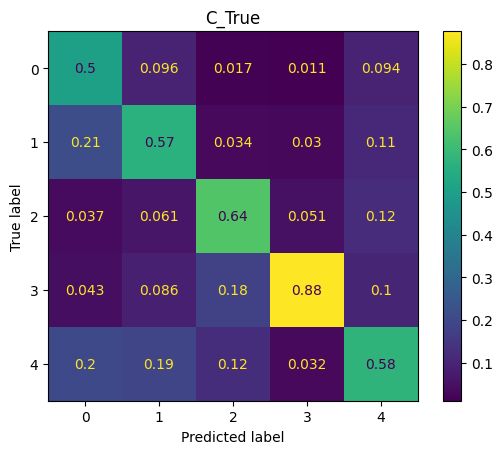

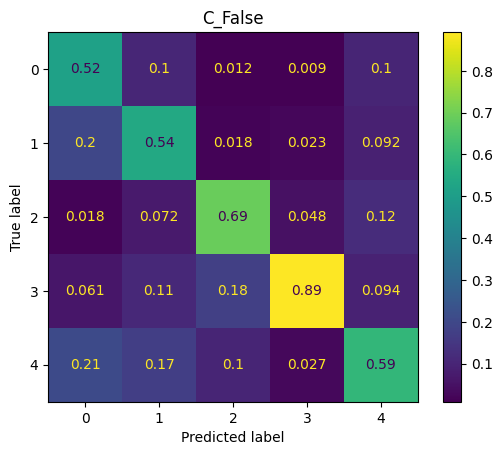

In [6]:
for lr in [True, False]:
    print(f"LR: {lr}")
    print(f"Start: {datetime.datetime.now()}")
    params = Params(255, 256, 50, 0.0075, True, 5, lr)
    print(params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
    model = create_model(tf.keras.applications.ConvNeXtTiny, "base", params)
    df_train, df_test = run_task(f"C_{lr}", model, ds_train, ds_valid, ds_test, params)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")

Model: <function ConvNeXtTiny at 0x7ff34b6dee60>
Start: 2024-03-30 18:26:17.732929
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.5131 - loss: 1.3472

W0000 00:00:1711823238.120625     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711823238.120933     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711823238.121416     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711823238.124480     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711823238.124862     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711823238.125423     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5145 - loss: 1.3442 - val_accuracy: 0.6554 - val_loss: 0.9205
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 942ms/step - accuracy: 0.6439 - loss: 0.9823 - val_accuracy: 0.6921 - val_loss: 0.8169
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 948ms/step - accuracy: 0.6676 - loss: 0.8896 - val_accuracy: 0.7107 - val_loss: 0.7734
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 943ms/step - accuracy: 0.6785 - loss: 0.8538 - val_accuracy: 0.7164 - val_loss: 0.7486
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 948ms/step - accuracy: 0.6940 - loss: 0.8194 - val_accuracy: 0.7259 - val_loss: 0.7314
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 944ms/step - accuracy: 0.6977 - loss: 0.7934 - val_accuracy: 0.7421 - val_loss: 0.7199
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 943ms/step - accuracy: 0.7132 - loss: 0.7747 - val_accuracy: 0.7400 - val_loss: 0.7076
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 948ms/step - accuracy: 0.7175 - loss: 0.7584 - val_accuracy: 0.7442 -

W0000 00:00:1711825685.762732     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711825685.763139     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711825685.763558     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711825685.769292     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711825685.769638     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711825685.770303     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.5125 - loss: 1.3568 - val_accuracy: 0.6537 - val_loss: 0.9253
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6374 - loss: 1.0066 - val_accuracy: 0.6832 - val_loss: 0.8465
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6609 - loss: 0.9098 - val_accuracy: 0.6981 - val_loss: 0.8069
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6682 - loss: 0.8799 - val_accuracy: 0.7072 - val_loss: 0.7835
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6773 - loss: 0.8450 - val_accuracy: 0.7180 - val_loss: 0.7638
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6991 - loss: 0.8195 - val_accuracy: 0.7222 - val_loss: 0.7531
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6985 - loss: 0.8000 - val_accuracy: 0.7238 - val_loss: 0.7425
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7046 - loss: 0.7819 - val_accuracy: 0.7334 - val_loss: 0.7265
Ep

W0000 00:00:1711829035.712552     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711829035.712869     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711829035.713305     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711829035.713689     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711829035.714065     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711829035.714428     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711829035.714812     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711829035.715203     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5361 - loss: 1.3380

W0000 00:00:1711829088.500795     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711829088.501390     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711829088.501887     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.5372 - loss: 1.3347 - val_accuracy: 0.6764 - val_loss: 0.8513
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6499 - loss: 0.9265 - val_accuracy: 0.7248 - val_loss: 0.7487
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6901 - loss: 0.8244 - val_accuracy: 0.7388 - val_loss: 0.7021
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7174 - loss: 0.7699 - val_accuracy: 0.7607 - val_loss: 0.6523
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7342 - loss: 0.7219 - val_accuracy: 0.7701 - val_loss: 0.6231
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7419 - loss: 0.6946 - val_accuracy: 0.7841 - val_loss: 0.6047
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7575 - loss: 0.6637 - val_accuracy: 0.7860 - val_loss: 0.5852
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7631 - loss: 0.6446 - val_accuracy: 0.7944 - val_loss: 0.

W0000 00:00:1711833320.033443     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711833320.033837     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711833320.034262     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_C_2.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7669 - loss: 0.6353
[0.4532824158668518, 0.8441588878631592]
End: 2024-03-30 21:15:55.937289


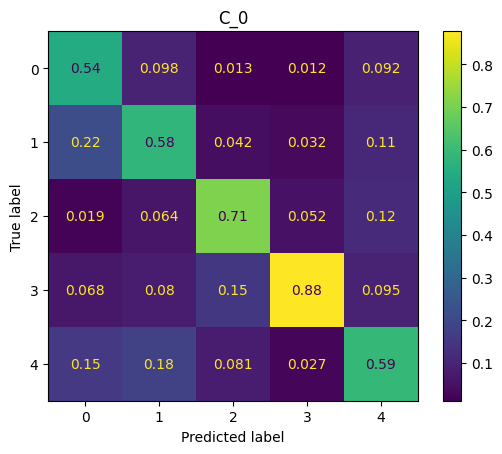

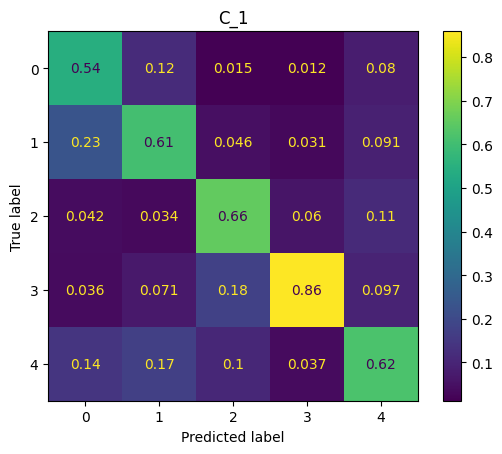

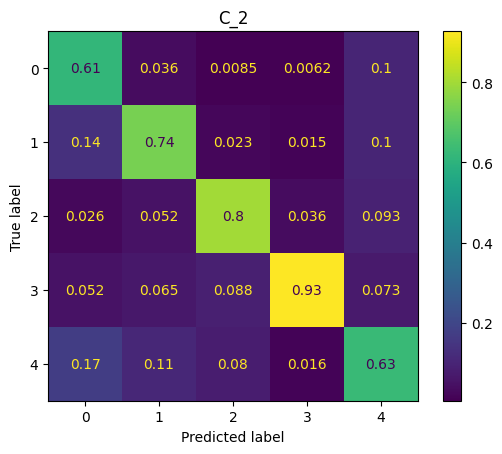

In [8]:
i = 0
for m in [tf.keras.applications.ConvNeXtTiny, tf.keras.applications.ConvNeXtSmall, tf.keras.applications.ConvNeXtBase]:
    print(f"Model: {m}")
    print(f"Start: {datetime.datetime.now()}")
    params = Params(255, 256, 50, 0.0075, True, 5, False)
    print(params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
    model = create_model(m, "base", params)
    df_train, df_test = run_task(f"C_{str(i)}", model, ds_train, ds_valid, ds_test, params)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")
    i = i + 1

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

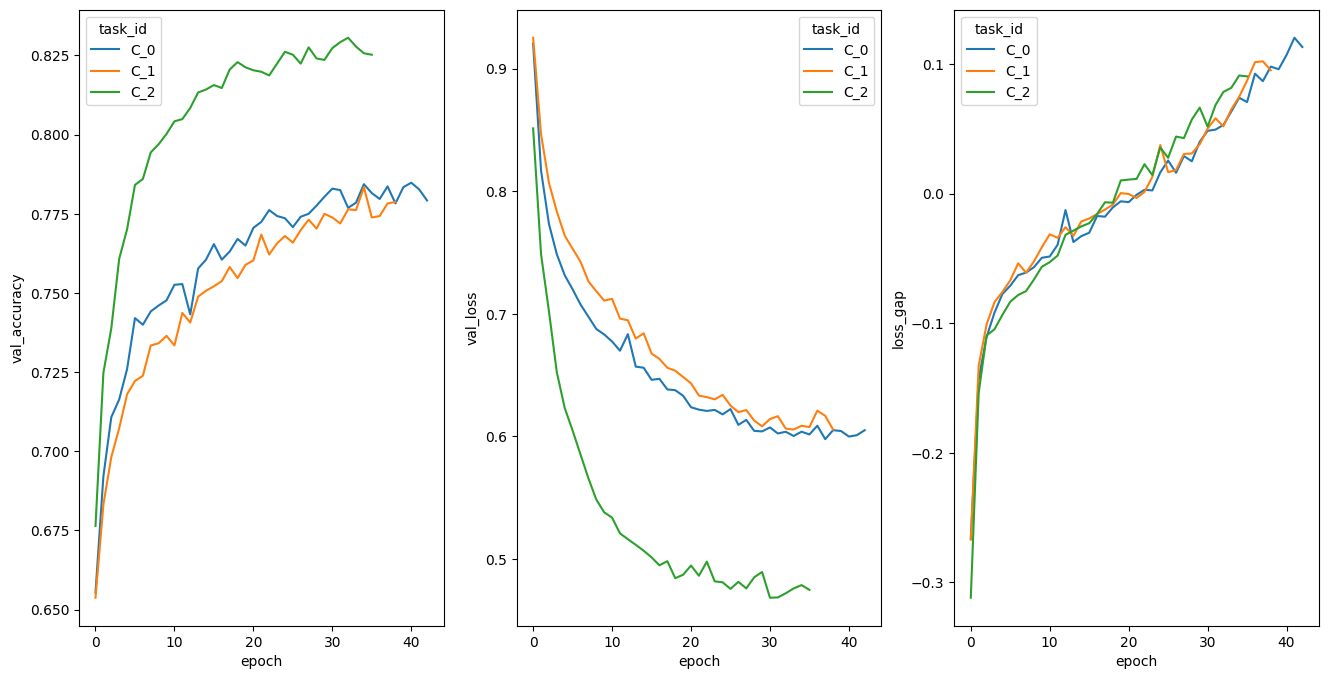

In [12]:
plot_experiments_comp2(collector.get_train_details(), ["C_0", "C_1", "C_2"])

In [13]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,C_True,0.600873,0.778037
0,C_False,0.594749,0.786916
0,C_0,0.587986,0.788084
0,C_1,0.598270,0.782944
0,C_2,0.453282,0.844159


Start: 2024-03-31 09:04:29.673986
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1711875938.771752     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711875938.826532     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/51 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.5433 - loss: 1.2881

W0000 00:00:1711876033.790162     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711876033.790544     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711876033.790949     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711876033.791349     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711876033.791709     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711876033.792085     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711876033.792500     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711876033.792879     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.5454 - loss: 1.2823 - val_accuracy: 0.6738 - val_loss: 0.8522
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6575 - loss: 0.9198 - val_accuracy: 0.7250 - val_loss: 0.7535
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6912 - loss: 0.8244 - val_accuracy: 0.7416 - val_loss: 0.7007
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7060 - loss: 0.7778 - val_accuracy: 0.7561 - val_loss: 0.6578
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7287 - loss: 0.7226 - val_accuracy: 0.7734 - val_loss: 0.6243
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7413 - loss: 0.6954 - val_accuracy: 0.7839 - val_loss: 0.6068
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7527 - loss: 0.6666 - val_accuracy: 0.7848 - val_loss: 0.5842
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7643 - loss: 0.6382 - val_accuracy: 0.7972 - val_loss: 0.

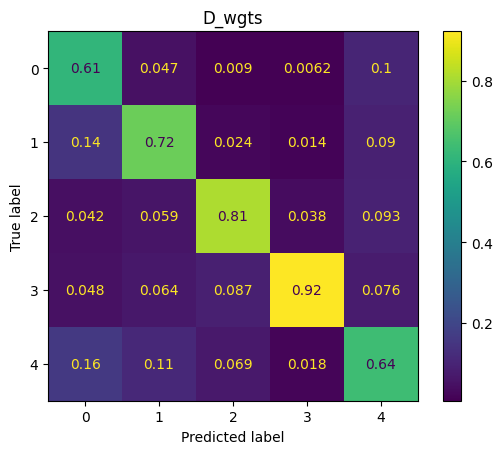

In [7]:
print(f"Start: {datetime.datetime.now()}")
params = Params(255, 256, 50, 0.0075, True, 7, False)
print(params)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
model = create_model(tf.keras.applications.ConvNeXtBase, "base", params)
df_train, df_test = run_task("D_wgts", model, ds_train, ds_valid, ds_test, params, class_weights)
collector.add_task_results(df_train, df_test)
print(model.model.evaluate(ds_test))
print(f"End: {datetime.datetime.now()}")

In [10]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,E_0,0.601456,0.781075
0,E_1,0.581891,0.796495


Model: <function ConvNeXtTiny at 0x78408edab2e0>
Start: 2024-03-31 11:28:04.056557
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1711884528.636584     136 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.5268 - loss: 1.3321

W0000 00:00:1711884570.417576     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711884570.417913     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711884570.418362     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711884570.419337     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711884570.419668     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711884570.419993     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711884570.420330     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711884570.420645     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.5279 - loss: 1.3294 - val_accuracy: 0.6577 - val_loss: 0.9210
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 968ms/step - accuracy: 0.6383 - loss: 0.9967 - val_accuracy: 0.6918 - val_loss: 0.8203
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 951ms/step - accuracy: 0.6691 - loss: 0.8902 - val_accuracy: 0.7098 - val_loss: 0.7754
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 949ms/step - accuracy: 0.6783 - loss: 0.8574 - val_accuracy: 0.7133 - val_loss: 0.7520
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 951ms/step - accuracy: 0.6888 - loss: 0.8230 - val_accuracy: 0.7269 - val_loss: 0.7365
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 953ms/step - accuracy: 0.6958 - loss: 0.8014 - val_accuracy: 0.7339 - val_loss: 0.7246
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 949ms/step - accuracy: 0.7063 - loss: 0.7820 - val_accuracy: 0.7348 - val_loss: 0.7115
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 949ms/step - accuracy: 0.7163 - loss: 0.7638 - val_accuracy: 0.7442 

W0000 00:00:1711886576.763137     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711886576.763479     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711886576.763933     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_E_0.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 658ms/step - accuracy: 0.6899 - loss: 0.8086
[0.6014561653137207, 0.7810747623443604]
End: 2024-03-31 12:03:19.550253
Model: <function EfficientNetB0 at 0x78408edcc0d0>
Start: 2024-03-31 12:03:19.550287
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Using EarlyStopping
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.5292 - loss: 1.2841

W0000 00:00:1711886763.473409     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.5304 - loss: 1.2814 - val_accuracy: 0.6486 - val_loss: 0.9060
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 570ms/step - accuracy: 0.6446 - loss: 0.9694 - val_accuracy: 0.6965 - val_loss: 0.7925
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 570ms/step - accuracy: 0.6725 - loss: 0.8669 - val_accuracy: 0.7215 - val_loss: 0.7408
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 578ms/step - accuracy: 0.6896 - loss: 0.8144 - val_accuracy: 0.7343 - val_loss: 0.7093
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 566ms/step - accuracy: 0.7059 - loss: 0.7838 - val_accuracy: 0.7397 - val_loss: 0.6892
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 580ms/step - accuracy: 0.7140 - loss: 0.7616 - val_accuracy: 0.7493 - val_loss: 0.6751
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 568ms/step - accuracy: 0.7256 - loss: 0.7339 - val_accuracy: 0.7519 - val_loss: 0.6648
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 33s 584ms/step - accuracy: 0.7355 - loss: 0.7163 - val_accuracy: 0.7505 

W0000 00:00:1711888047.449128     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_E_1.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - accuracy: 0.7138 - loss: 0.7885
[0.5818905830383301, 0.7964953184127808]
End: 2024-03-31 12:27:41.870107


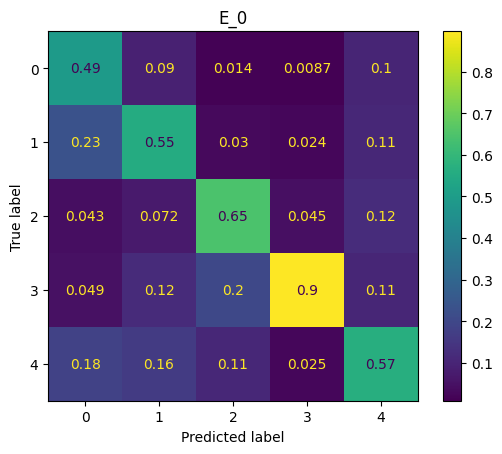

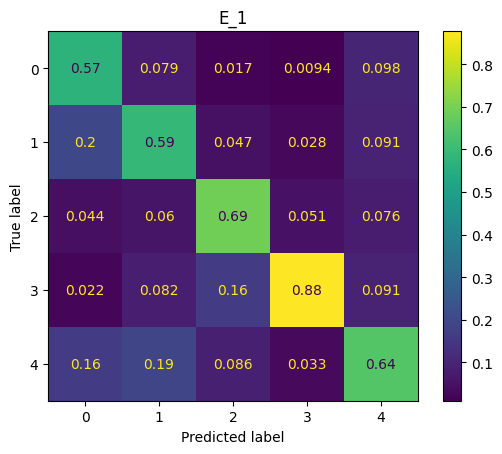

In [7]:
i = 0
for m in [tf.keras.applications.ConvNeXtTiny, tf.keras.applications.EfficientNetB0]:
    print(f"Model: {m}")
    print(f"Start: {datetime.datetime.now()}")
    params = Params(255, 256, 50, 0.0075, True, 5, False)
    print(params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
    model = create_model(m, "base", params)
    df_train, df_test = run_task(f"E_{str(i)}", model, ds_train, ds_valid, ds_test, params, class_weights)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")
    i = i + 1

Model: <function EfficientNetV2B0 at 0x78408edccc10>
Start: 2024-03-31 12:29:54.035031
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Using EarlyStopping
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4777 - loss: 1.3806   

W0000 00:00:1711888351.994448     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.4795 - loss: 1.3774 - val_accuracy: 0.6231 - val_loss: 0.9586
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 560ms/step - accuracy: 0.6354 - loss: 0.9998 - val_accuracy: 0.6972 - val_loss: 0.8094
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 547ms/step - accuracy: 0.6706 - loss: 0.8791 - val_accuracy: 0.7257 - val_loss: 0.7474
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 555ms/step - accuracy: 0.6882 - loss: 0.8371 - val_accuracy: 0.7409 - val_loss: 0.7164
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 549ms/step - accuracy: 0.6982 - loss: 0.7991 - val_accuracy: 0.7465 - val_loss: 0.6993
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 545ms/step - accuracy: 0.7154 - loss: 0.7745 - val_accuracy: 0.7512 - val_loss: 0.6823
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 547ms/step - accuracy: 0.7223 - loss: 0.7546 - val_accuracy: 0.7556 - val_loss: 0.6719
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 538ms/step - accuracy: 0.7293 - loss: 0.7348 - val_accuracy: 0.7572 

W0000 00:00:1711889513.087371     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_E_2.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - accuracy: 0.7182 - loss: 0.7621
[0.5527278780937195, 0.8102803826332092]
End: 2024-03-31 12:52:06.900138


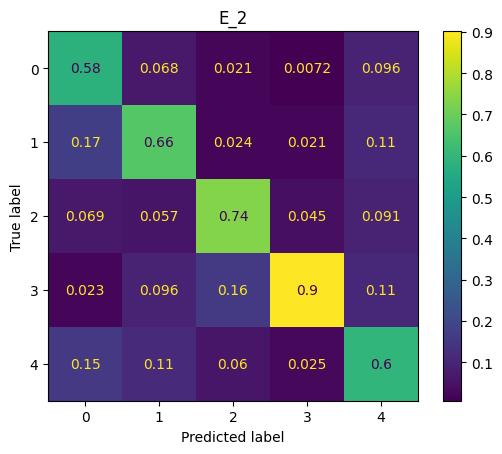

In [11]:
i = 2
for m in [tf.keras.applications.EfficientNetV2B0]:
    print(f"Model: {m}")
    print(f"Start: {datetime.datetime.now()}")
    params = Params(255, 256, 50, 0.0075, True, 5, False)
    print(params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
    model = create_model(m, "base", params)
    df_train, df_test = run_task(f"E_{str(i)}", model, ds_train, ds_valid, ds_test, params, class_weights)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")
    i = i + 1

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

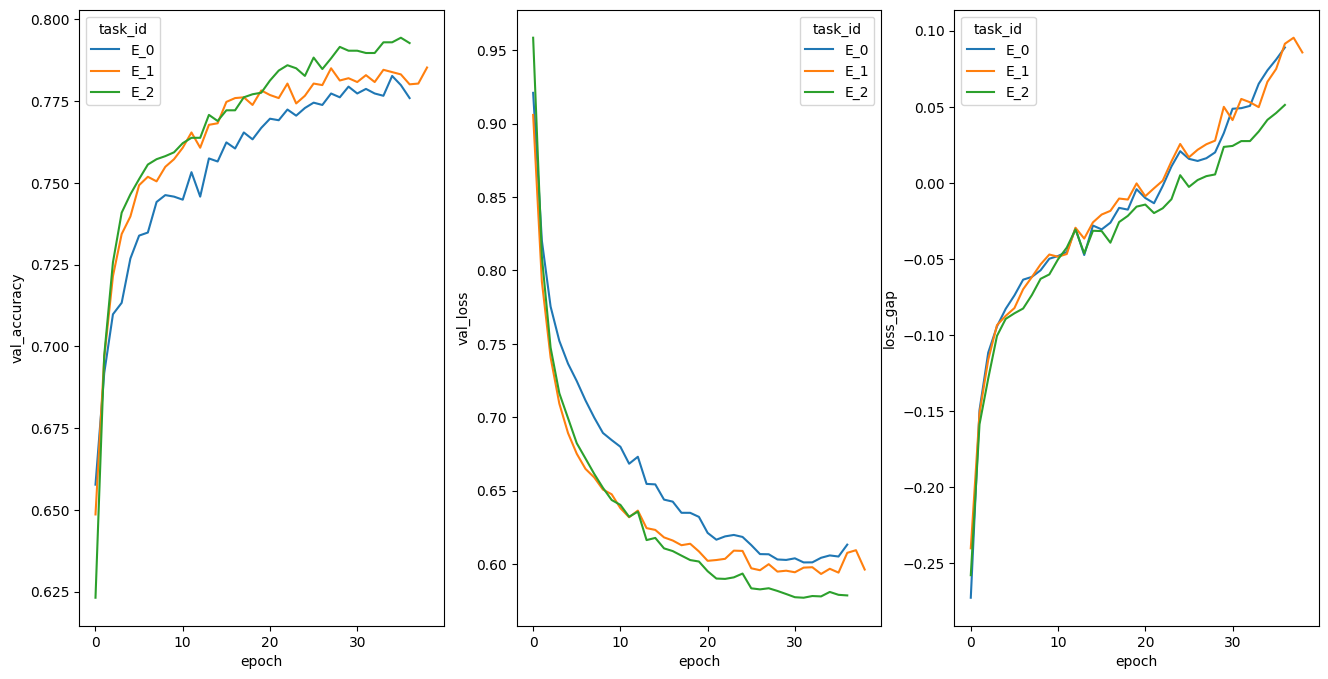

In [14]:
plot_experiments_comp2(collector.get_train_details(), ["E_0", "E_1", "E_2"])

In [13]:
m1 = create_model_ablations(tf.keras.applications.ConvNeXtTiny, "base", params, 2, 1024)
m1.model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,662,309 (113.15 MB)

 Trainable params: 1,842,181 (7.03 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Model: <function ConvNeXtTiny at 0x7c3445dfee60>
Start: 2024-03-31 13:07:39.354785
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1711890501.273158     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.4936 - loss: 1.3876

W0000 00:00:1711890543.005257     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711890543.005621     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711890543.006184     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711890543.007148     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711890543.007499     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711890543.007844     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711890543.008176     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711890543.008514     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.4952 - loss: 1.3842 - val_accuracy: 0.6593 - val_loss: 0.9137
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 949ms/step - accuracy: 0.6399 - loss: 0.9897 - val_accuracy: 0.6890 - val_loss: 0.8153
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 944ms/step - accuracy: 0.6698 - loss: 0.8903 - val_accuracy: 0.7042 - val_loss: 0.7733
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 960ms/step - accuracy: 0.6815 - loss: 0.8630 - val_accuracy: 0.7121 - val_loss: 0.7518
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 950ms/step - accuracy: 0.6937 - loss: 0.8229 - val_accuracy: 0.7208 - val_loss: 0.7343
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 949ms/step - accuracy: 0.6933 - loss: 0.7985 - val_accuracy: 0.7334 - val_loss: 0.7197
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.7150 - loss: 0.7755 - val_accuracy: 0.7339 - val_loss: 0.7105
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 944ms/step - accuracy: 0.7206 - loss: 0.7570 - val_accuracy: 0.7416 

W0000 00:00:1711893099.174094     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_C_0.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 655ms/step - accuracy: 0.6992 - loss: 0.7831
[0.5895998477935791, 0.7857476472854614]
End: 2024-03-31 13:51:57.800818
Model: <function ConvNeXtBase at 0x7c3445dfef80>
Start: 2024-03-31 13:51:57.800848
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step
Using EarlyStopping
Epoch 1/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.5253 - loss: 1.3336

W0000 00:00:1711893305.285599     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711893305.285966     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711893305.286394     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711893305.286788     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711893305.287151     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711893305.287544     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711893305.287915     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711893305.288289     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5266 - loss: 1.3302

W0000 00:00:1711893358.970868     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711893358.971228     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711893358.971727     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.5278 - loss: 1.3270 - val_accuracy: 0.6745 - val_loss: 0.8596
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6536 - loss: 0.9371 - val_accuracy: 0.7154 - val_loss: 0.7593
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6834 - loss: 0.8412 - val_accuracy: 0.7439 - val_loss: 0.6974
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7127 - loss: 0.7670 - val_accuracy: 0.7591 - val_loss: 0.6551
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7310 - loss: 0.7309 - val_accuracy: 0.7694 - val_loss: 0.6290
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7448 - loss: 0.6957 - val_accuracy: 0.7827 - val_loss: 0.5997
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7559 - loss: 0.6672 - val_accuracy: 0.7869 - val_loss: 0.5778
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7639 - loss: 0.6310 - val_accuracy: 0.7946 - val_loss: 0.

W0000 00:00:1711897786.353873     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711897786.354203     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711897786.354680     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_C_1.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7704 - loss: 0.6268
[0.4594534635543823, 0.8441588878631592]
End: 2024-03-31 15:10:22.487972
Model: <function EfficientNetV2B0 at 0x7c3445c20790>
Start: 2024-03-31 15:10:22.488000
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Using EarlyStopping
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5407 - loss: 1.2859   

W0000 00:00:1711897980.958151     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.5417 - loss: 1.2837 - val_accuracy: 0.6297 - val_loss: 0.9344
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 555ms/step - accuracy: 0.6418 - loss: 0.9828 - val_accuracy: 0.6972 - val_loss: 0.8014
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 561ms/step - accuracy: 0.6704 - loss: 0.8830 - val_accuracy: 0.7245 - val_loss: 0.7467
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 560ms/step - accuracy: 0.6875 - loss: 0.8342 - val_accuracy: 0.7379 - val_loss: 0.7199
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 560ms/step - accuracy: 0.7021 - loss: 0.7897 - val_accuracy: 0.7472 - val_loss: 0.6997
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 557ms/step - accuracy: 0.7111 - loss: 0.7742 - val_accuracy: 0.7481 - val_loss: 0.6842
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 552ms/step - accuracy: 0.7188 - loss: 0.7542 - val_accuracy: 0.7512 - val_loss: 0.6728
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 557ms/step - accuracy: 0.7323 - loss: 0.7214 - val_accuracy: 0.7549 

W0000 00:00:1711899471.199593     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_C_2.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - accuracy: 0.7236 - loss: 0.7719
[0.5541859269142151, 0.8109813332557678]
End: 2024-03-31 15:38:05.012199
Model: <function EfficientNetV2M at 0x7c3445c20a60>
Start: 2024-03-31 15:38:05.012236
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Using EarlyStopping
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4659 - loss: 1.3772   

W0000 00:00:1711899887.004511     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 390s 4s/step - accuracy: 0.4678 - loss: 1.3745 - val_accuracy: 0.6175 - val_loss: 1.0598
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6212 - loss: 1.0784 - val_accuracy: 0.6458 - val_loss: 0.9498
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6365 - loss: 0.9891 - val_accuracy: 0.6673 - val_loss: 0.8817
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6473 - loss: 0.9510 - val_accuracy: 0.6841 - val_loss: 0.8374
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6576 - loss: 0.9063 - val_accuracy: 0.6911 - val_loss: 0.8035
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6763 - loss: 0.8720 - val_accuracy: 0.7056 - val_loss: 0.7776
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6758 - loss: 0.8604 - val_accuracy: 0.7192 - val_loss: 0.7611
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6948 - loss: 0.8276 - val_accuracy: 0.7178 - val_loss: 0.7468
Ep

W0000 00:00:1711902978.490145     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_C_3.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 742ms/step - accuracy: 0.6831 - loss: 0.8403
[0.607708752155304, 0.785981297492981]
End: 2024-03-31 16:36:42.620970


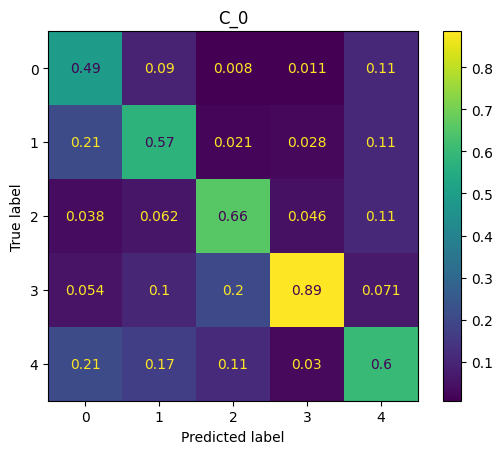

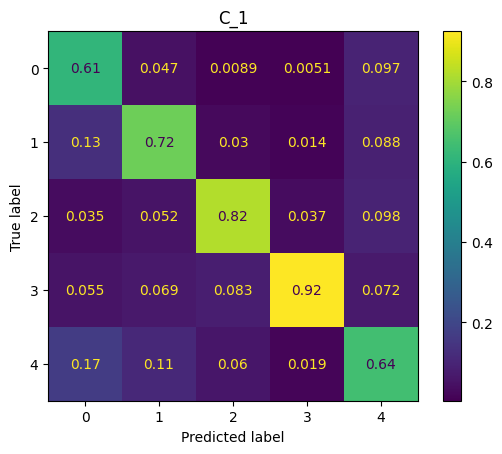

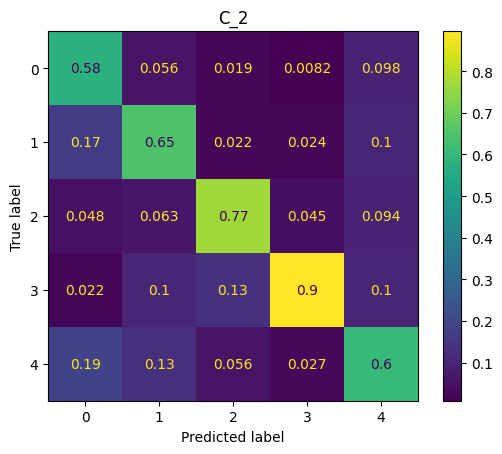

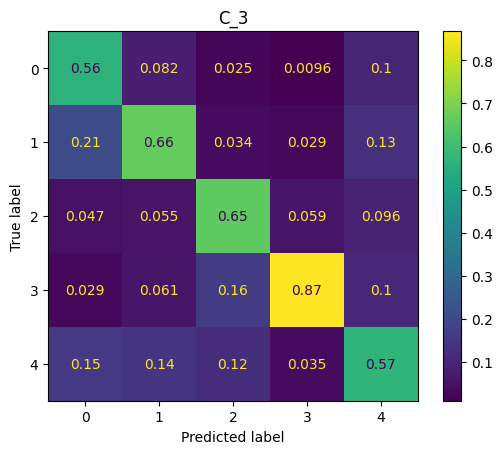

In [8]:
i = 0
params = Params(255, 256, 50, 0.0075, True, 7, False)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
for m in [tf.keras.applications.ConvNeXtTiny, tf.keras.applications.ConvNeXtBase,
          tf.keras.applications.EfficientNetV2B0, tf.keras.applications.EfficientNetV2M]:
    print(f"Model: {m}")
    print(f"Start: {datetime.datetime.now()}")
    print(params)
    model = create_model(m, "base", params)
    df_train, df_test = run_task(f"C_{str(i)}", model, ds_train, ds_valid, ds_test, params, class_weights)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")
    i = i + 1

In [9]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,C_0,0.589600,0.785748
0,C_1,0.459453,0.844159
0,C_2,0.554186,0.810981
0,C_3,0.607709,0.785981


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

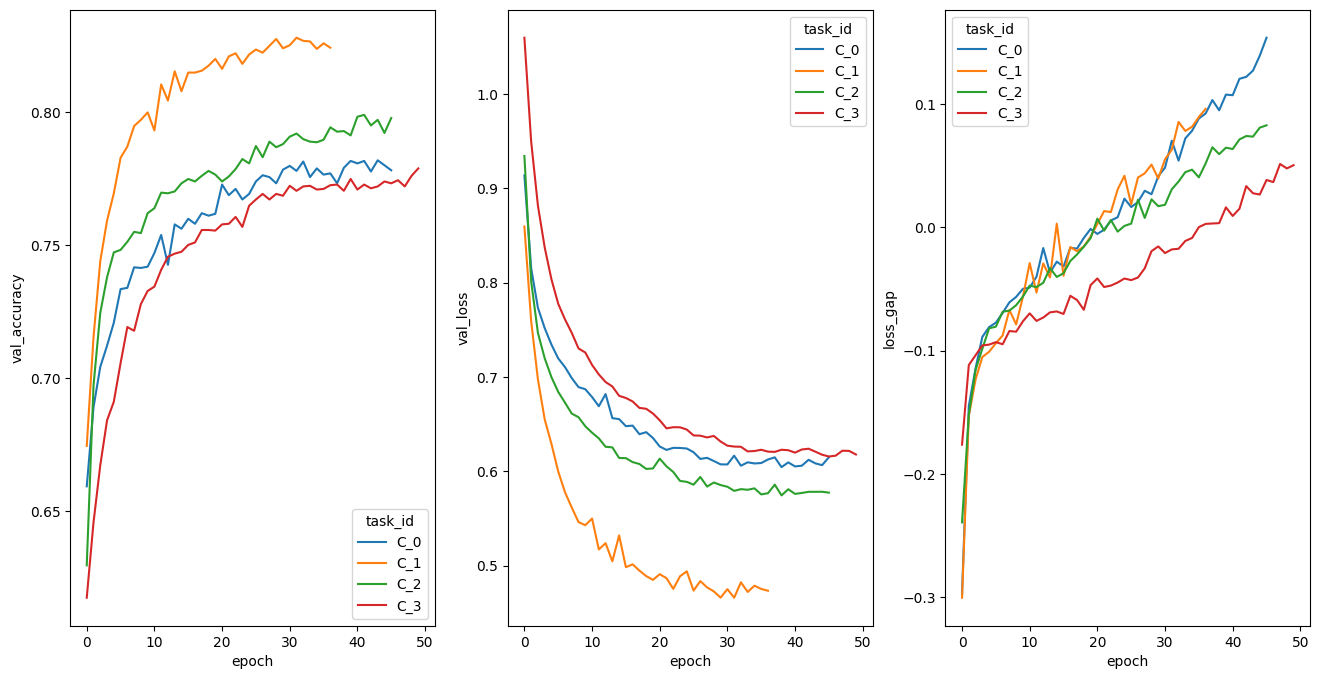

In [10]:
plot_experiments_comp2(collector.get_train_details(), ["C_0", "C_1", "C_2", "C_3"])

In [ ]:
i = 0
params = Params(255, 256, 50, 0.0075, True, 7, False)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
ds_train_aug = augment_dataset(ds_train, 2)
for m in [tf.keras.applications.ConvNeXtTiny, tf.keras.applications.EfficientNetV2B0]:
    print(f"Model: {m}")
    print(f"Start: {datetime.datetime.now()}")
    print(params)
    model = create_model(m, "base", params)
    df_train, df_test = run_task(f"D_{str(i)}", model, ds_train_aug, ds_valid, ds_test, params, class_weights)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")
    i = i + 1

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Model: <function ConvNeXtTiny at 0x794c9f792ef0>
Start: 2024-03-31 17:12:21.602260
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1711905180.768105     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 51/102 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.5117 - loss: 1.3601   

W0000 00:00:1711905233.940656     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711905233.941067     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711905233.941509     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711905233.942421     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711905233.942747     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711905233.943070     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711905233.943400     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711905233.943713     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/102 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.5563 - loss: 1.2510 - val_accuracy: 0.6879 - val_loss: 0.8299
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 805ms/step - accuracy: 0.6663 - loss: 0.9008 - val_accuracy: 0.7143 - val_loss: 0.7543
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 795ms/step - accuracy: 0.6902 - loss: 0.8203 - val_accuracy: 0.7292 - val_loss: 0.7251
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 797ms/step - accuracy: 0.7082 - loss: 0.7785 - val_accuracy: 0.7390 - val_loss: 0.7044
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 799ms/step - accuracy: 0.7164 - loss: 0.7521 - val_accuracy: 0.7439 - val_loss: 0.6895
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 799ms/step - accuracy: 0.7276 - loss: 0.7290 - val_accuracy: 0.7491 - val_loss: 0.6763
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 799ms/step - accuracy: 0.7367 - loss: 0.7080 - val_accuracy: 0.7514 - val_loss: 0.6648
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 796ms/step - accuracy: 0.7443 - loss: 0.6913 - val_a

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Model: <function EfficientNetV2B0 at 0x7dc495dd0790>
Start: 2024-03-31 18:29:11.342148
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Using EarlyStopping
Epoch 1/50
  1/102 ━━━━━━━━━━━━━━━━━━━━ 1:56:02 69s/step - accuracy: 0.2031 - loss: 1.6340

I0000 00:00:1711909823.650939     145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


102/102 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.5639 - loss: 1.2150 - val_accuracy: 0.6984 - val_loss: 0.8134
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 29s 284ms/step - accuracy: 0.6725 - loss: 0.8787 - val_accuracy: 0.7376 - val_loss: 0.7232
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 276ms/step - accuracy: 0.7041 - loss: 0.7994 - val_accuracy: 0.7460 - val_loss: 0.6921
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - accuracy: 0.7232 - loss: 0.7555 - val_accuracy: 0.7512 - val_loss: 0.6667
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - accuracy: 0.7322 - loss: 0.7261 - val_accuracy: 0.7563 - val_loss: 0.6521
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 278ms/step - accuracy: 0.7381 - loss: 0.7072 - val_accuracy: 0.7612 - val_loss: 0.6381
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 279ms/step - accuracy: 0.7466 - loss: 0.6866 - val_accuracy: 0.7621 - val_loss: 0.6298
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 279ms/step - accuracy: 0.7534 - loss: 0.6733 - val_a

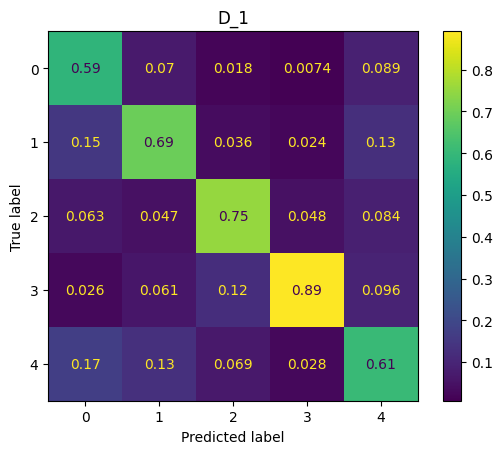

In [7]:
# out of memory ^
i = 1
params = Params(255, 256, 50, 0.0075, True, 7, False)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
ds_train_aug = augment_dataset(ds_train, 2)
for m in [tf.keras.applications.EfficientNetV2B0]:
    print(f"Model: {m}")
    print(f"Start: {datetime.datetime.now()}")
    print(params)
    model = create_model(m, "base", params)
    df_train, df_test = run_task(f"D_{str(i)}", model, ds_train_aug, ds_valid, ds_test, params, class_weights)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")
    i = i + 1

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
#FC: 1 - 1024
Start: 2024-04-01 12:47:08.561161
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,236,181 (27.60 MB)

 Trainable params: 1,316,869 (5.02 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Using EarlyStopping
Epoch 1/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 57:06 69s/step - accuracy: 0.1406 - loss: 1.8072

I0000 00:00:1711975699.331180     165 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.5156 - loss: 1.2936 - val_accuracy: 0.6577 - val_loss: 0.8809
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 88s 558ms/step - accuracy: 0.6648 - loss: 0.9067 - val_accuracy: 0.7166 - val_loss: 0.7684
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 555ms/step - accuracy: 0.6889 - loss: 0.8194 - val_accuracy: 0.7341 - val_loss: 0.7269
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 556ms/step - accuracy: 0.7096 - loss: 0.7792 - val_accuracy: 0.7465 - val_loss: 0.7000
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 554ms/step - accuracy: 0.7255 - loss: 0.7459 - val_accuracy: 0.7456 - val_loss: 0.6866
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 562ms/step - accuracy: 0.7277 - loss: 0.7275 - val_accuracy: 0.7514 - val_loss: 0.6713
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 550ms/step - accuracy: 0.7324 - loss: 0.7120 - val_accuracy: 0.7572 - val_loss: 0.6605
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 555ms/step - accuracy: 0.7452 - loss: 0.6936 - val_accuracy: 0.7607 

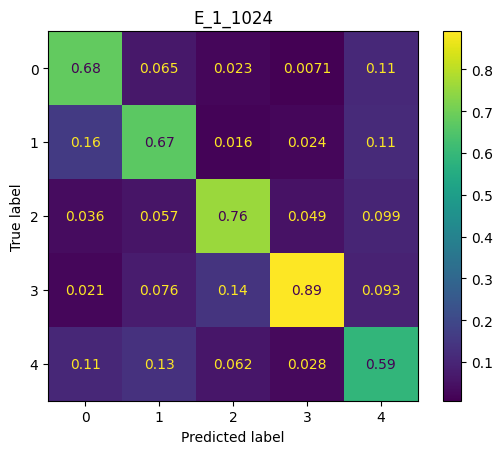

In [7]:
params = Params(255, 256, 50, 0.0075, True, 7, False)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
print(f"#FC: 1 - 1024")
print(f"Start: {datetime.datetime.now()}")
print(params)
model = create_model_ablations(tf.keras.applications.EfficientNetV2B0, "base", params, 1, 1024)
print(model.model.summary())
df_train, df_test = run_task(f"E_1_1024", model, ds_train, ds_valid, ds_test, params, class_weights)
collector.add_task_results(df_train, df_test)
print(model.model.evaluate(ds_test))
print(f"End: {datetime.datetime.now()}")

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
No Class Weights
Start: 2024-04-01 13:19:46.171372
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,285,781 (31.61 MB)

 Trainable params: 2,366,469 (9.03 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Using EarlyStopping
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5275 - loss: 1.2928 - val_accuracy: 0.6346 - val_loss: 0.9323
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 612ms/step - accuracy: 0.6409 - loss: 0.9842 - val_accuracy: 0.6984 - val_loss: 0.8002
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 611ms/step - accuracy: 0.6771 - loss: 0.8763 - val_accuracy: 0.7322 - val_loss: 0.7449
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 565ms/step - accuracy: 0.6966 - loss: 0.8257 - val_accuracy: 0.7381 - val_loss: 0.7177
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 33s 586ms/step - accuracy: 0.7022 - loss: 0.7872 - val_accuracy: 0.7435 - val_loss: 0.7017
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 563ms/step - accuracy: 0.7115 - loss: 0.7682 - val_accuracy: 0.7500 - val_loss: 0.6830
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 614ms/step - accuracy: 0.7297 - loss: 0.7326 - val_accuracy: 0.7521 - val_loss: 0.6721
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 570ms/step - accuracy: 0.7341 - 

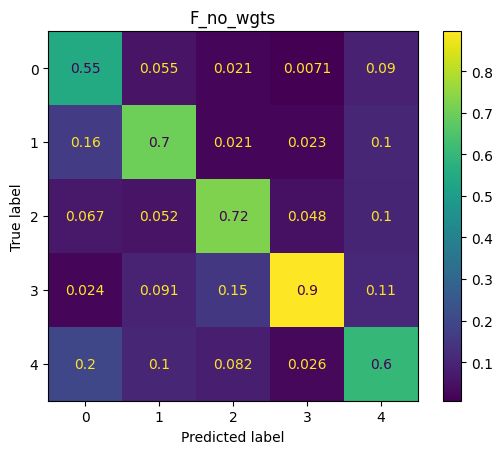

In [8]:
params = Params(255, 256, 50, 0.0075, True, 7, False)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
print(f"No Class Weights")
print(f"Start: {datetime.datetime.now()}")
print(params)
model = create_model_ablations(tf.keras.applications.EfficientNetV2B0, "base", params, 2, 1024)
print(model.model.summary())
df_train, df_test = run_task(f"F_no_wgts", model, ds_train, ds_valid, ds_test, params)
collector.add_task_results(df_train, df_test)
print(model.model.evaluate(ds_test))
print(f"End: {datetime.datetime.now()}")

### Task G - Custom Model

In [ ]:
params = Params(255, 256, 50, 0.0075, True, 7, False)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
print(f"Custom Model")
print(f"Start: {datetime.datetime.now()}")
print(params)
model = create_simple_model(params)
print(model.model.summary())
df_train, df_test = run_task(f"G_cust_model", model, convert_dataset(ds_train), convert_dataset(ds_valid), convert_dataset(ds_test), params)
collector.add_task_results(df_train, df_test)
print(model.model.evaluate(ds_test))
print(f"End: {datetime.datetime.now()}")

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Custom Model
Start: 2024-04-01 14:03:56.448973
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 255, 255, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 255, 255, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 127, 127, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 127, 127, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 63, 63, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 63, 63, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 63, 63, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    62,980,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,681,957 (242.93 MB)

 Trainable params: 63,681,957 (242.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Using EarlyStopping
Epoch 1/50


2024-04-01 14:04:20.333735: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,3,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,3,255,255]{3,2,1,0}, f32[256,32,255,255]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 14:04:21.263925: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.930343881s
Trying algorithm eng0{} for conv (f32[32,3,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,3,255,255]{3,2,1,0}, f32[256,32,255,255]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 14:04:24.739757: E external/

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5729 - loss: 1.2961   

W0000 00:00:1711980392.992429     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711980427.078988     165 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.5734 - loss: 1.2951 - val_accuracy: 0.6164 - val_loss: 1.2136
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 788ms/step - accuracy: 0.6122 - loss: 1.1968 - val_accuracy: 0.6171 - val_loss: 1.2310
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 799ms/step - accuracy: 0.6123 - loss: 1.1562 - val_accuracy: 0.6203 - val_loss: 1.1721
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 797ms/step - accuracy: 0.6143 - loss: 1.1256 - val_accuracy: 0.6255 - val_loss: 1.0967
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 787ms/step - accuracy: 0.6200 - loss: 1.1013 - val_accuracy: 0.6322 - val_loss: 1.1053
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 795ms/step - accuracy: 0.6218 - loss: 1.0900 - val_accuracy: 0.6269 - val_loss: 1.0386
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 794ms/step - accuracy: 0.6240 - loss: 1.1020 - val_accuracy: 0.6360 - val_loss: 1.0222
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 787ms/step - accuracy: 0.6100 - loss: 1.1656 - val_accuracy: 0.6364 

### Task H: Fine-Tune

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Fine Tune
Start: 2024-04-01 14:34:33.055439
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,285,781 (31.61 MB)

 Trainable params: 2,366,469 (9.03 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Using EarlyStopping
Epoch 1/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 54:49 66s/step - accuracy: 0.2578 - loss: 1.6115

I0000 00:00:1711982141.675694     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5396 - loss: 1.2932 - val_accuracy: 0.6327 - val_loss: 0.9384
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 547ms/step - accuracy: 0.6393 - loss: 0.9907 - val_accuracy: 0.7016 - val_loss: 0.7970
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.6730 - loss: 0.8700 - val_accuracy: 0.7271 - val_loss: 0.7417
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 552ms/step - accuracy: 0.6891 - loss: 0.8339 - val_accuracy: 0.7404 - val_loss: 0.7138
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 546ms/step - accuracy: 0.7059 - loss: 0.7804 - val_accuracy: 0.7479 - val_loss: 0.6951
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 549ms/step - accuracy: 0.7154 - loss: 0.7646 - val_accuracy: 0.7495 - val_loss: 0.6819
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 546ms/step - accuracy: 0.7223 - loss: 0.7447 - val_accuracy: 0.7570 - val_loss: 0.6711
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.7389 - loss: 0.7222 - val_accuracy: 0.7582 

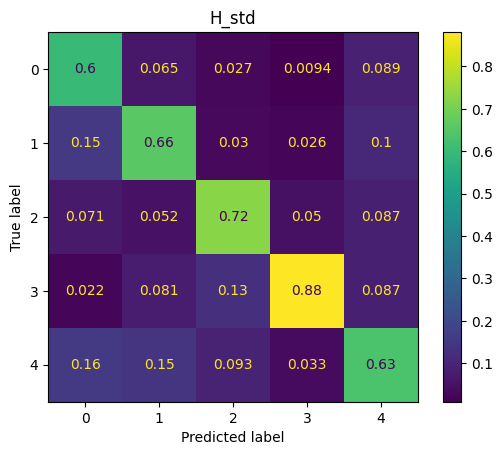

In [7]:
params = Params(255, 256, 50, 0.0075, True, 7, False)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
print(f"Fine Tune")
print(f"Start: {datetime.datetime.now()}")
print(params)
model = create_model_ablations(tf.keras.applications.EfficientNetV2B0, "base", params, 2, 1024)
print(model.model.summary())
df_train, df_test = run_task(f"H_std", model, ds_train, ds_valid, ds_test, params, class_weights)
collector.add_task_results(df_train, df_test)
print(model.model.evaluate(ds_test))
print(f"End: {datetime.datetime.now()}")

In [8]:
model.base_model.trainable = True

Fine Tune
Start: 2024-04-01 14:57:56.481410
Params(image_size=255, batch_size=256, epochs=50, epsilon=1e-05, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
Using EarlyStopping
Epoch 1/50


2024-04-01 14:59:26.509782: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,32,64,64]{3,2,1,0}, f32[256,128,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 14:59:27.006946: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.497250114s
Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,32,64,64]{3,2,1,0}, f32[256,128,64,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 14:59:28.537924: E external/

51/51 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.7092 - loss: 0.8380 - val_accuracy: 0.8332 - val_loss: 0.4668
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 819ms/step - accuracy: 0.8529 - loss: 0.4107 - val_accuracy: 0.8143 - val_loss: 0.5405
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 821ms/step - accuracy: 0.9029 - loss: 0.2781 - val_accuracy: 0.8234 - val_loss: 0.7763
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 821ms/step - accuracy: 0.8995 - loss: 0.3009 - val_accuracy: 0.8280 - val_loss: 0.6248
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 825ms/step - accuracy: 0.9438 - loss: 0.1626 - val_accuracy: 0.8220 - val_loss: 0.7661
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 823ms/step - accuracy: 0.9608 - loss: 0.1097 - val_accuracy: 0.8264 - val_loss: 0.7753
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 815ms/step - accuracy: 0.9699 - loss: 0.0890 - val_accuracy: 0.8203 - val_loss: 0.8150
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 814ms/step - accuracy: 0.9733 - loss: 0.0817 - val_accuracy: 0.8238 

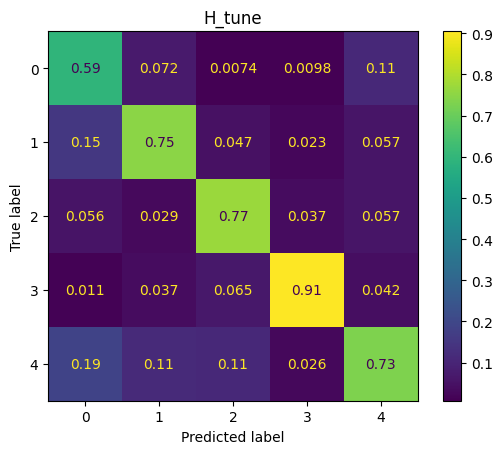

In [9]:
params = Params(255, 256, 50, 1e-5, True, 7, False)
print(f"Fine Tune")
print(f"Start: {datetime.datetime.now()}")
print(params)
df_train, df_test = run_task(f"H_tune", model, ds_train, ds_valid, ds_test, params, class_weights)
collector.add_task_results(df_train, df_test)
print(model.model.evaluate(ds_test))
print(f"End: {datetime.datetime.now()}")

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Crop
Start: 2024-04-02 10:07:14.225373
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,285,781 (31.61 MB)

 Trainable params: 2,366,469 (9.03 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Using EarlyStopping
Epoch 1/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 55:48 67s/step - accuracy: 0.1367 - loss: 1.7437

I0000 00:00:1712052503.047326     147 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.4944 - loss: 1.3273

W0000 00:00:1712052583.585508     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.4961 - loss: 1.3244 - val_accuracy: 0.6379 - val_loss: 0.9312
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 509ms/step - accuracy: 0.6403 - loss: 0.9799 - val_accuracy: 0.6995 - val_loss: 0.7999
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 512ms/step - accuracy: 0.6754 - loss: 0.8743 - val_accuracy: 0.7217 - val_loss: 0.7410
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 504ms/step - accuracy: 0.6869 - loss: 0.8291 - val_accuracy: 0.7444 - val_loss: 0.7094
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 503ms/step - accuracy: 0.7078 - loss: 0.7949 - val_accuracy: 0.7491 - val_loss: 0.6897
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - accuracy: 0.7182 - loss: 0.7522 - val_accuracy: 0.7521 - val_loss: 0.6716
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 507ms/step - accuracy: 0.7281 - loss: 0.7359 - val_accuracy: 0.7603 - val_loss: 0.6590
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 508ms/step - accuracy: 0.7364 - loss: 0.7228 - val_accuracy: 0.7617 

W0000 00:00:1712053794.837794     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_I.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - accuracy: 0.7179 - loss: 0.7690
[0.5418745279312134, 0.8121495246887207]
End: 2024-04-02 10:30:12.163981


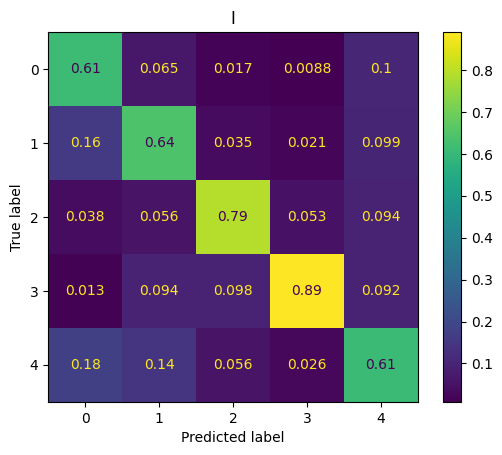

In [7]:
params = Params(255, 256, 50, 0.0075, True, 7, False)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
print(f"Crop")
print(f"Start: {datetime.datetime.now()}")
print(params)
model = create_model_ablations(tf.keras.applications.EfficientNetV2B0, "base", params, 2, 1024)
print(model.model.summary())
df_train, df_test = run_task(f"I", model, ds_train, ds_valid, ds_test, params, class_weights)
collector.add_task_results(df_train, df_test)
print(model.model.evaluate(ds_test))
print(f"End: {datetime.datetime.now()}")

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
FC #n: 256
Start: 2024-03-31 20:02:01.865856
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,314,325 (24.09 MB)

 Trainable params: 395,013 (1.51 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Using EarlyStopping
Epoch 1/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 57:12 69s/step - accuracy: 0.2266 - loss: 1.6858

I0000 00:00:1711915392.107581     400 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.4776 - loss: 1.3913 - val_accuracy: 0.6166 - val_loss: 1.0200
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 550ms/step - accuracy: 0.6183 - loss: 1.0746 - val_accuracy: 0.6477 - val_loss: 0.8931
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 545ms/step - accuracy: 0.6449 - loss: 0.9663 - val_accuracy: 0.6841 - val_loss: 0.8235
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 555ms/step - accuracy: 0.6623 - loss: 0.9144 - val_accuracy: 0.7056 - val_loss: 0.7798
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 541ms/step - accuracy: 0.6785 - loss: 0.8649 - val_accuracy: 0.7201 - val_loss: 0.7522
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 539ms/step - accuracy: 0.6821 - loss: 0.8459 - val_accuracy: 0.7348 - val_loss: 0.7288
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.6987 - loss: 0.8111 - val_accuracy: 0.7458 - val_loss: 0.7114
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 541ms/step - accuracy: 0.7033 - loss: 0.7973 - val_accuracy: 0.7493 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,840,405 (26.09 MB)

 Trainable params: 921,093 (3.51 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Using EarlyStopping
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.5096 - loss: 1.3299 - val_accuracy: 0.6180 - val_loss: 0.9673
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 561ms/step - accuracy: 0.6306 - loss: 1.0225 - val_accuracy: 0.6886 - val_loss: 0.8377
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 558ms/step - accuracy: 0.6636 - loss: 0.9168 - val_accuracy: 0.7222 - val_loss: 0.7719
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 556ms/step - accuracy: 0.6823 - loss: 0.8526 - val_accuracy: 0.7355 - val_loss: 0.7332
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 556ms/step - accuracy: 0.6954 - loss: 0.8241 - val_accuracy: 0.7442 - val_loss: 0.7132
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step - accuracy: 0.7060 - loss: 0.7851 - val_accuracy: 0.7442 - val_loss: 0.6998
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 552ms/step - accuracy: 0.7165 - loss: 0.7715 - val_accuracy: 0.7491 - val_loss: 0.6862
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 561ms/step - accuracy: 0.7203 - 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2048)           │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,749,397 (48.64 MB)

 Trainable params: 6,830,085 (26.05 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Using EarlyStopping
Epoch 1/50
 1/51 ━━━━━━━━━━━━━━━━━━━━ 40:25 49s/step - accuracy: 0.1250 - loss: 1.7728

W0000 00:00:1711918860.001381     403 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5133 - loss: 1.2980   

W0000 00:00:1711918922.200248     401 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711918930.375598     401 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.5148 - loss: 1.2951 - val_accuracy: 0.6610 - val_loss: 0.8985
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 549ms/step - accuracy: 0.6506 - loss: 0.9356 - val_accuracy: 0.7206 - val_loss: 0.7727
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 552ms/step - accuracy: 0.6908 - loss: 0.8382 - val_accuracy: 0.7367 - val_loss: 0.7235
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 547ms/step - accuracy: 0.7024 - loss: 0.7971 - val_accuracy: 0.7397 - val_loss: 0.7089
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 549ms/step - accuracy: 0.7197 - loss: 0.7654 - val_accuracy: 0.7465 - val_loss: 0.6939
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 554ms/step - accuracy: 0.7267 - loss: 0.7463 - val_accuracy: 0.7493 - val_loss: 0.6704
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 554ms/step - accuracy: 0.7360 - loss: 0.7274 - val_accuracy: 0.7556 - val_loss: 0.6573
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 561ms/step - accuracy: 0.7396 - loss: 0.7114 - val_accuracy: 0.7593 

W0000 00:00:1711920245.191731     401 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 770ms/step


W0000 00:00:1711920257.510461     403 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_E_2_2048.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - accuracy: 0.7326 - loss: 0.7470
[0.5494843125343323, 0.8126168251037598]
End: 2024-03-31 21:24:31.983225


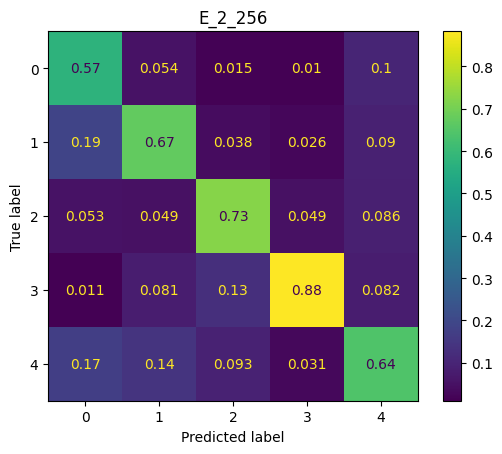

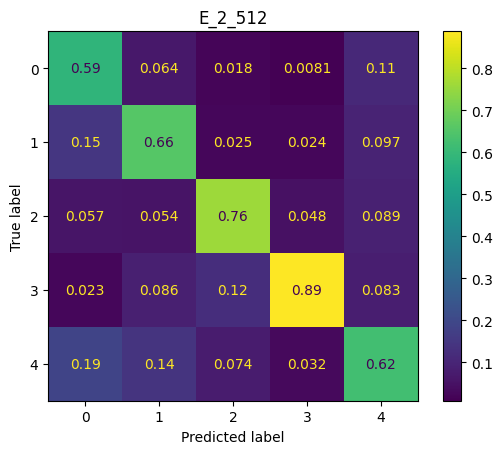

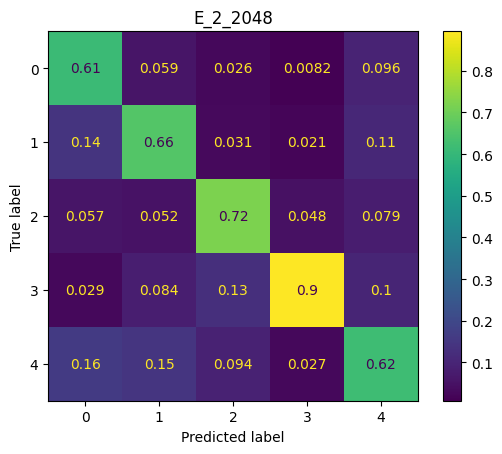

In [7]:
params = Params(255, 256, 50, 0.0075, True, 7, False)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
for n in [256, 512, 2048]:
    print(f"FC #n: {n}")
    print(f"Start: {datetime.datetime.now()}")
    print(params)
    model = create_model_ablations(tf.keras.applications.EfficientNetV2B0, "base", params, 2, n)
    print(model.model.summary())
    df_train, df_test = run_task(f"E_2_{str(n)}", model, ds_train, ds_valid, ds_test, params, class_weights)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

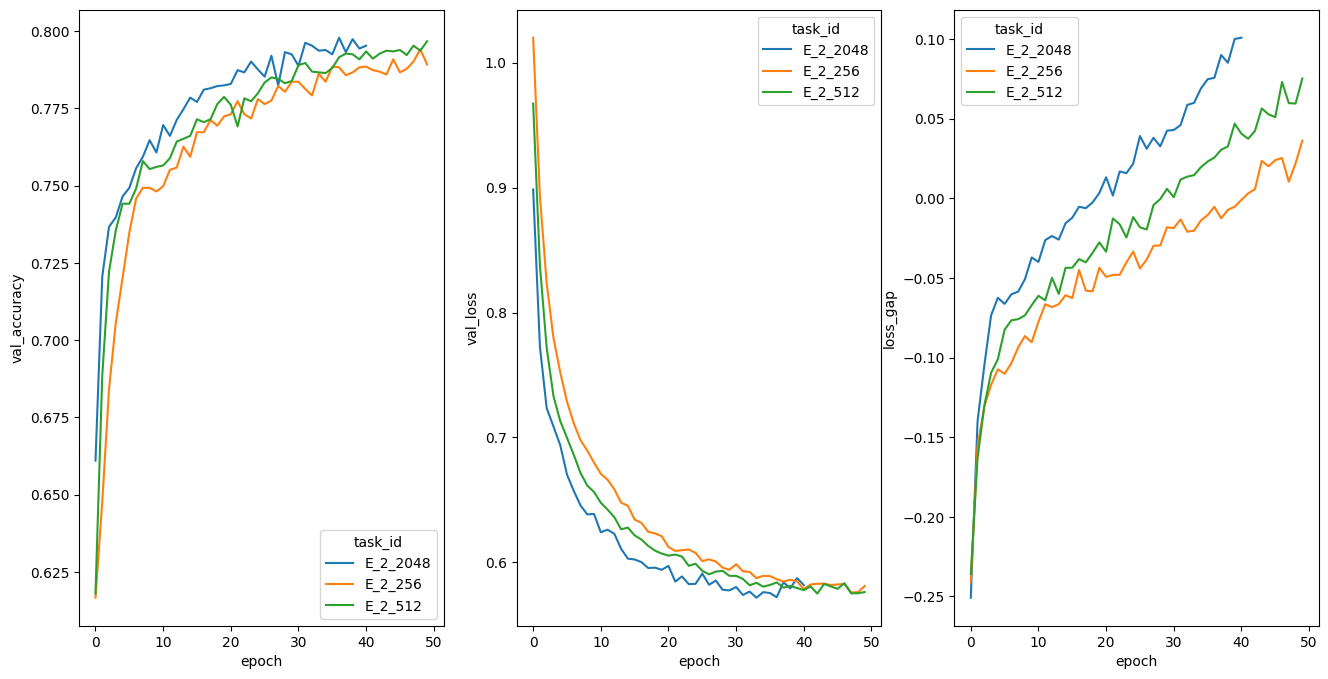

In [9]:
plot_experiments_comp2(collector.get_train_details(), ["E_2_256", "E_2_512", "E_2_2048"])

In [8]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,E_2_256,0.558991,0.810748
0,E_2_512,0.557612,0.812150
0,E_2_2048,0.549484,0.812617


Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
FC #n: 256
Start: 2024-03-31 21:27:56.296145
Params(image_size=255, batch_size=128, epochs=50, epsilon=0.0075, early_stopping=True, early_stopping_patience=7, adjust_learning_rate=False)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,248,533 (23.84 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Using EarlyStopping
Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 132s 737ms/step - accuracy: 0.5528 - loss: 1.2193 - val_accuracy: 0.7007 - val_loss: 0.8088
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 286ms/step - accuracy: 0.6821 - loss: 0.8642 - val_accuracy: 0.7332 - val_loss: 0.7260
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - accuracy: 0.7107 - loss: 0.7777 - val_accuracy: 0.7467 - val_loss: 0.7018
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 283ms/step - accuracy: 0.7213 - loss: 0.7547 - val_accuracy: 0.7523 - val_loss: 0.6720
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - accuracy: 0.7352 - loss: 0.7237 - val_accuracy: 0.7579 - val_loss: 0.6655
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 31s 288ms/step - accuracy: 0.7374 - loss: 0.7118 - val_accuracy: 0.7631 - val_loss: 0.6476
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 282ms/step - accuracy: 0.7465 - loss: 0.6876 - val_accuracy: 0.7652 - val_loss: 0.6348
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 286ms/step - 

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,577,749 (25.09 MB)

 Trainable params: 658,437 (2.51 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Using EarlyStopping
Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 110s 665ms/step - accuracy: 0.5972 - loss: 1.1592 - val_accuracy: 0.7093 - val_loss: 0.7872
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 283ms/step - accuracy: 0.6917 - loss: 0.8249 - val_accuracy: 0.7442 - val_loss: 0.7146
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - accuracy: 0.7186 - loss: 0.7593 - val_accuracy: 0.7488 - val_loss: 0.6874
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - accuracy: 0.7333 - loss: 0.7251 - val_accuracy: 0.7558 - val_loss: 0.6683
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 283ms/step - accuracy: 0.7361 - loss: 0.7156 - val_accuracy: 0.7626 - val_loss: 0.6524
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 282ms/step - accuracy: 0.7479 - loss: 0.6867 - val_accuracy: 0.7614 - val_loss: 0.6498
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 285ms/step - accuracy: 0.7542 - loss: 0.6692 - val_accuracy: 0.7682 - val_loss: 0.6280
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 283ms/step - 

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,236,181 (27.60 MB)

 Trainable params: 1,316,869 (5.02 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

None
Using EarlyStopping
Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 113s 701ms/step - accuracy: 0.5509 - loss: 1.2146 - val_accuracy: 0.7065 - val_loss: 0.7872
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - accuracy: 0.6930 - loss: 0.8227 - val_accuracy: 0.7418 - val_loss: 0.7069
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 286ms/step - accuracy: 0.7226 - loss: 0.7489 - val_accuracy: 0.7519 - val_loss: 0.6757
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - accuracy: 0.7405 - loss: 0.7166 - val_accuracy: 0.7568 - val_loss: 0.6638
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - accuracy: 0.7474 - loss: 0.6906 - val_accuracy: 0.7596 - val_loss: 0.6471
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 283ms/step - accuracy: 0.7502 - loss: 0.6799 - val_accuracy: 0.7643 - val_loss: 0.6405
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 282ms/step - accuracy: 0.7625 - loss: 0.6487 - val_accuracy: 0.7659 - val_loss: 0.6273
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 31s 290ms/step - 

KeyboardInterrupt: 

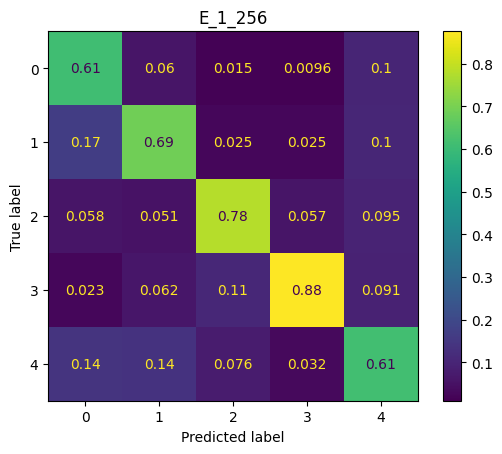

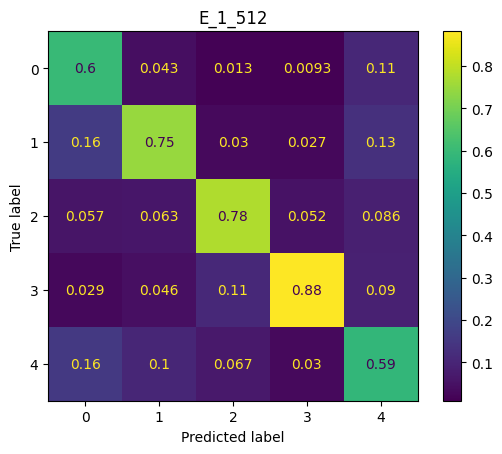

In [10]:
params = Params(255, 128, 50, 0.0075, True, 7, False)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
for n in [256, 512, 1024, 2048]:
    print(f"FC #n: {n}")
    print(f"Start: {datetime.datetime.now()}")
    print(params)
    model = create_model_ablations(tf.keras.applications.EfficientNetV2B0, "base", params, 1, n)
    print(model.model.summary())
    df_train, df_test = run_task(f"E_1_{str(n)}", model, ds_train, ds_valid, ds_test, params, class_weights)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

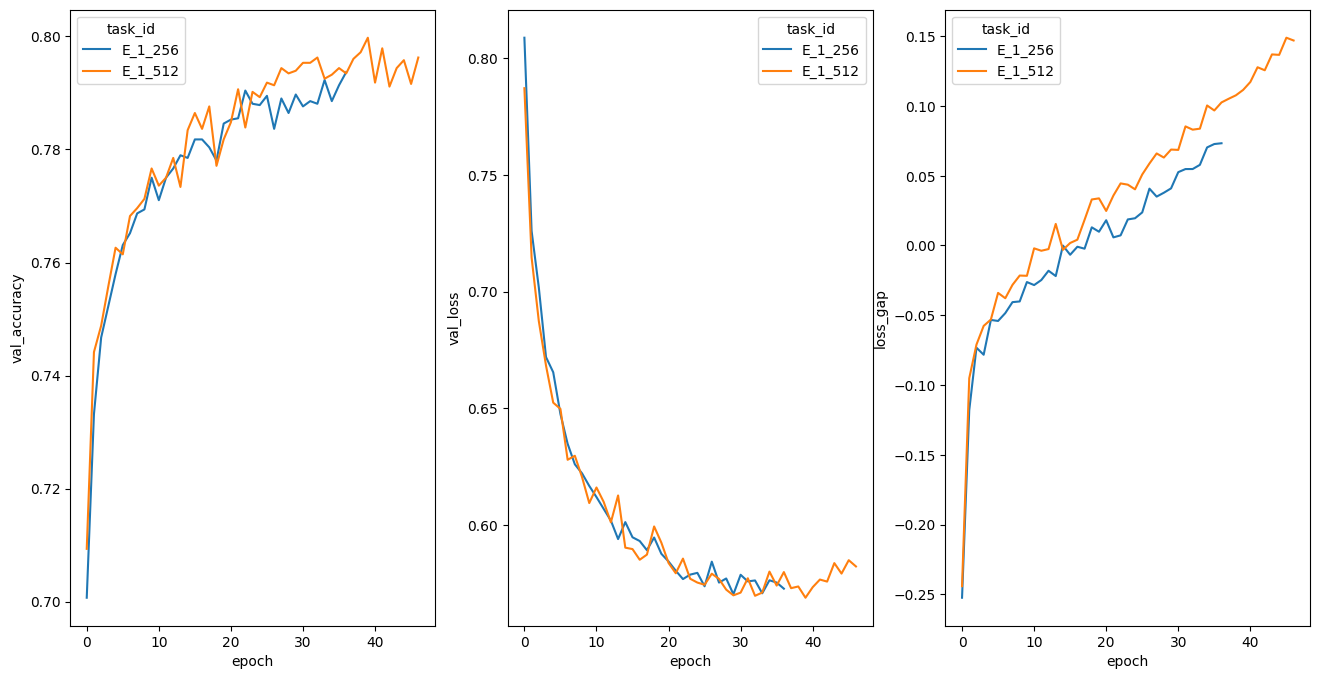

In [13]:
plot_experiments_comp2(collector.get_train_details(), ["E_1_256", "E_1_512"])

In [ ]:
print(f"Start: {datetime.datetime.now()}")
params = Params(255, 256, 50, 0.0075, True, 7, False)
print(params)
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
model = create_model(tf.keras.applications.EfficientNetB0, "base", params)
ds_train_aug = augment_dataset(ds_train, 2)
df_train, df_test = run_task("F", model, ds_train_aug, ds_valid, ds_test, params, class_weights)
collector.add_task_results(df_train, df_test)
print(model.model.evaluate(ds_test))
print(f"End: {datetime.datetime.now()}")

In [12]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,E_2_256,0.558991,0.810748
0,E_2_512,0.557612,0.812150
0,E_2_2048,0.549484,0.812617
0,E_1_256,0.553586,0.809112
0,E_1_512,0.546196,0.811449


In [ ]:
tf.keras.applications.EfficientNetB0

In [ ]:
i = 0
for aug in [1, 2]:
    print(f"Repeats: {aug}")
    print(f"Start: {datetime.datetime.now()}")
    params = Params(255, 256, 50, 0.0075, True, 5, False)
    print(params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
    model = create_model(tf.keras.applications.ConvNeXtBase, "base", params)
    df_train, df_test = run_task(f"C_{str(i)}", model, ds_train, ds_valid, ds_test, params)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")
    i = i + 1

In [ ]:
print(datetime.datetime.now())
model_z = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("Z_base", model_z, ds_train, ds_valid, ds_test, DEFAULT_PARAMS)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [ ]:
print(datetime.datetime.now())
ds_train_aug = augment_dataset(ds_train, 3)
model_y = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("Y_base", model_y, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [ ]:
print(datetime.datetime.now())
ds_train_aug = augment_dataset(ds_train, 2)
model_b = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("B_base_aug", model_b, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [ ]:
model_b.model.save("/kaggle/working/artefacts/model_b.keras")

In [ ]:
del model_b
del model

In [ ]:
print(datetime.datetime.now())
ds_train_aug = augment_dataset(ds_train, 2)
model_c = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("C_base_aug_wgts", model_c, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
collector.add_task_results(df_train, df_test)  
print(datetime.datetime.now())

In [ ]:
model_c.model.save("/kaggle/working/artefacts/model_c.keras")

In [ ]:
model_c.model.evaluate(ds_test)

In [ ]:
pd.read_csv("/kaggle/working/artefacts/test_scores.csv")

In [ ]:
collector.get_test_scores()

In [ ]:
del model_c

In [ ]:
print(datetime.datetime.now())
fine_tune_params = Params(50, 196, 1, 1e-5, True, 5, False)
print(fine_tune_params)
model_c.base_model.trainable = True
df_train, df_test = run_task("D_base_aug_wgts_ft", model_c, ds_train, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [ ]:
print(datetime.datetime.now())
ds_train_aug = augment_dataset(ds_train, 2)
model_d = create_model(tf.keras.applications.ConvNeXtTiny, "baseline", DEFAULT_PARAMS)
df_train, df_test = run_task("B_base_aug", model_d, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
ARTEFACTS_PATH = Path("artefacts")
ARTEFACTS_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
ARTEFACTS_PATH

In [ ]:
collector = ResultCollector(ARTEFACTS_PATH)
collector.add_task_results(df_train, df_test)
collector.add_task_results(df_train2, df_test2)

In [ ]:
collector.add_train_details(df_train)
collector.add_test_scores(df_test)

In [ ]:
collector.get_train_details()

In [ ]:
collector.get_test_scores()

In [ ]:
pd.read_csv(ARTEFACTS_PATH / "train_details.csv")

In [ ]:
pd.read_csv(ARTEFACTS_PATH / "test_scores.csv")

`older_code`

In [ ]:
#!rm -rf /kaggle/working/data
#!rm /kaggle/working/data.zip

In [ ]:
# import keras

# import pandas as pd
# import random
# import shutil
# import tensorflow as tf
# import os
# import zipfile

# from collections import Counter

# from pathlib import Path
# from sklearn.model_selection import train_test_split

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from tensorflow.keras import layers, callbacks
# from tensorflow.keras.models import Model


# from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

# from tensorflow.data import Dataset

# from typing import NamedTuple, Tuple

# import matplotlib.pyplot as plt
# import seaborn as sns

In [ ]:
# def data_cleanup() -> None:
#     # clean-up
#     try:
#         os.rmdir((data_path / "train_images"))
#         os.remove(file)
#     except Exception:
#          pass

In [ ]:
df = create_test_record("test_task", [1.0, 2.0])

In [ ]:
pd.concat([df, create_test_record("test_task", [1.0, 2.0])])

In [ ]:




# Large VGG-like model
def fatVGG(cifarInput, num_classes, name="vgg"):
    name = [name+str(i) for i in range(17)]
    
    # convolution and max pooling layers
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[0])(cifarInput)
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[1])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[2])(vgg)
    vgg = Dropout(0.25, name=name[3])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[4])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[5])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[6])(vgg)
    vgg = Dropout(0.25, name=name[7])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[8])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[9])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[10])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[11])(vgg)
    vgg = Dropout(0.25, name=name[12])(vgg)

    # classification layers
    vgg = Flatten(name=name[13])(vgg)
    vgg = Dense(512, activation='relu', name=name[14])(vgg)
    vgg = Dropout(0.5, name=name[15])(vgg)
    vgg = Dense(num_classes, activation='softmax', name=name[16])(vgg)
    return vgg


def model_convnext_tiny(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_convnext_base(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_convnext_tiny_1fc(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_effnet(params: Params) -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_effnetv2(params: Params) -> Model:
    
    base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def effnet2(params: Params) -> Model:
    base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = False
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model
    
    
#keras.utils.plot_model(mod.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


def train(task_id: str, model: Model,
             ds_train_: Dataset, ds_valid_: Dataset,
             params: Params, weights = None) -> pd.DataFrame:
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
   
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["task_id"] = task_id
    df_hist["epoch"] = df_hist.index
   
    return df_hist


def run_experiment(exp_id: str, sub_exp_id: int, model_fn: str,
                      ds_train_: Dataset, ds_valid_: Dataset, params: Params, weights = None) -> Tuple[Model, pd.DataFrame]:
    
    model = model_fn(params)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
    
    
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist

In [ ]:
def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])
    

def add_test_results(df_all_results: pd.DataFrame, exp_id: str, res: list[float]):
    df_res = pd.DataFrame({"exp_id": [exp_id], "test_loss" : [res[0]], "test_accuracy": [res[1]]})
    if df_all_results.empty:
        return df_res
    else:
        return pd.concat([df_all_results, df_res])


def recover_results() -> pd.DataFrame:
    file = "results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame()


def recover_test_results() -> pd.DataFrame:
    file = "test_results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame()

In [11]:
def plot_experiment_results(df_history: pd.DataFrame, exp_id: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id == exp_id) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_loss = df[["epoch", "loss", "val_loss"]].groupby(["epoch"]).mean()
    df_loss_gap = df[["epoch", "loss_gap"]].groupby(["epoch"]).mean()
    df_acc = df[["epoch", "accuracy", "val_accuracy"]].groupby(["epoch"]).mean()
    df_loss.plot()
    df_loss_gap.plot()
    df_acc.plot();
    
def plot_experiments_comp(df_history: pd.DataFrame, exp_id: list, y_dim: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", y_dim]].groupby(["epoch", "exp_id"]).mean()
    sns.lineplot(data=df_grp, x="epoch", y=y_dim, hue="exp_id")

In [12]:
def plot_experiments_comp2(df_history: pd.DataFrame, exp_id: list, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", "val_accuracy", "val_loss", "loss_gap"]].groupby(["epoch", "exp_id"]).mean()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))
    sns.lineplot(data=df_grp, x="epoch", y="val_accuracy", hue="exp_id",  ax=ax1)
    sns.lineplot(data=df_grp, x="epoch", y="val_loss", hue="exp_id",  ax=ax2)
    sns.lineplot(data=df_grp, x="epoch", y="loss_gap", hue="exp_id",  ax=ax3)

`main.py`

In [ ]:
cwd = os.getcwd()
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), DEFAULT_PARAMS)
print(f"Class Weights: {class_weights}")

#df_results = recover_results()
#df_test_results = recover_test_results()

In [ ]:
# augmented datasets
#ds_train_aug = augment_dataset(ds_train, 1)
#ds_train_aug_lg = augment_dataset(ds_train, 2)
#ds_train_aug_xlg = augment_dataset(ds_train, 4)

In [ ]:
df_results.head()

In [ ]:
df_test_results.head()

`experiments/tasks`

In [ ]:
DEFAULT_PARAMS = Params(255, 196, 2, True, 5, False)

In [ ]:
ARTIFACTS_PATH = Path("artefacts").mkdir(parents=True, exist_ok=True)


In [ ]:
def run_task(task_id: str, model_wrapper: ModelWrapper,
             ds_train_: Dataset, ds_valid_: Dataset, ds_test_: Dataset,
             params: Params, weights = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    model = model_wrapper.model
    # train
    df_train = train(task_id, model, ds_train, ds_valid, DEFAULT_PARAMS)
    # test
    test_result = model.evaluate(ds_test)
    df_test = create_test_record(task_id, test_result)
    # save CM too
    save_confusion_matrix(ds_test, model, task_id)
    return df_train, df_test

In [ ]:
def create_test_record(task_id: str, result: list[float]):
    return pd.DataFrame({"task_id": [task_id], "test_loss" : [result[0]], "test_accuracy": [result[1]]})

In [ ]:
baseline_model = create_model(tf.keras.applications.ConvNeXtBase, "baseline_model", DEFAULT_PARAMS)
df_train, df_test = run_task("convnextbase", baseline_model, ds_train, ds_valid, ds_test, DEFAULT_PARAMS)

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
    df_train = run_task("model_convnext_tiny", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

In [ ]:
df_results = add_results(df_results, df_hist)

In [ ]:
df_results

In [ ]:
baseline_model.model.evaluate(ds_valid)

In [ ]:
tr = baseline_model.model.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "convnext_tiny", tr)
tr

In [ ]:
baseline_model.base_model.trainable = True
df_hist2 = run_task("convnext_tiny_ft", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

In [ ]:
tr2 = baseline_model.model.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "convnext_tiny_ft", tr2)
tr2

In [ ]:
df_test_results

In [ ]:
plot_confusion_matrix(ds_test, baseline_model.model)

In [ ]:
df_hist = run_task("model_convnext_tiny", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

In [ ]:
(m, df_hist) = run_experiment("model_convnext_tiny", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m.evaluate(ds_test)

In [ ]:
(m1, df_hist) = run_experiment("model_convnext_base_orig_img", 1, model_convnext_base, augment_dataset(ds_train, 4), ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1.evaluate(ds_test)

In [ ]:
(m1a, df_hist) = run_experiment("model_convnext_base_orig_img_all", 1, model_convnext_base, augment_dataset(ds_train, 1), ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1.evaluate(ds_test)

In [ ]:
(m1b, df_hist) = run_experiment("model_convnext_base_orig_img_all_no_wgt", 1, model_convnext_base, augment_dataset(ds_train, 1), ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1b.evaluate(ds_test)

In [ ]:
(m2, df_hist) = run_experiment("model_convnext_tiny_aug_sm", 1, model_convnext_tiny, ds_train_aug, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m2.evaluate(ds_test)

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug", "model_convnext_tiny_aug4_sm"], "val_accuracy")

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug"], "val_loss")

In [ ]:
(m3, df_hist) = run_experiment("model_convnext_tiny_aug4_sm", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m3.evaluate(ds_test)

In [ ]:
df_results.head()

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_accuracy")

In [ ]:
(m4, df_hist) = run_experiment("model_convnext_tiny_1fc", 1, model_convnext_tiny_1fc, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m4.evaluate(ds_test)

In [ ]:
plot_experiments_comp2(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_loss")

In [ ]:
(m4, df_hist) = run_experiment("model_effnetv2", 1, model_effnetv2, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m4.evaluate(ds_test)

In [ ]:
(m5, df_hist) = run_experiment("model_effnet", 1, model_effnet, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

r5 = m5.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "model_effnet", r5)
print(r5)

In [ ]:
(m6, df_hist) = run_experiment("model_effnet_wgts", 1, model_effnet, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

r6 = m6.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "model_effnet", r6)
print(r6)

In [ ]:
print(r6)

In [ ]:
(m7, df_hist) = run_experiment("effnet2", 1, effnet2, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

r7 = m7.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "effnet2", r6)
print(r7)

In [ ]:
plot_experiments_comp2(df_results,["model_effnet", "model_effnet_wgts"])

In [ ]:
plot_experiments_comp2(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_effnetv2", "model_effnet"])

In [ ]:
params = DEFAULT_PARAMS
weights = class_weights
    
base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
#x = keras.layers.Dense(1024, activation="relu")(x)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=params.early_stopping_patience,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.3, 
    patience = 3, min_delta = 0.001, 
    mode = 'min', verbose = 1)

cbs = []
if params.early_stopping:
    print("Using EarlyStopping")
    cbs += [early_stopping]
if params.adjust_learning_rate:
    print("Using ReduceLROnPlateau")
    cbs += [reduce_lr]

history = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = None
)


In [ ]:
model.evaluate(ds_test)

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history2 = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight=None
)

In [ ]:
model.evaluate(ds_test)
# [0.4968397915363312, 0.8268691301345825]

In [ ]:
model_eff = model

In [ ]:
params = DEFAULT_PARAMS
weights = class_weights
    
base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=params.early_stopping_patience,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.3, 
    patience = 3, min_delta = 0.001, 
    mode = 'min', verbose = 1)

cbs = []
if params.early_stopping:
    print("Using EarlyStopping")
    cbs += [early_stopping]
if params.adjust_learning_rate:
    print("Using ReduceLROnPlateau")
    cbs += [reduce_lr]

history = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = weights
)

In [ ]:
model.evaluate(ds_test)

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history2 = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = weights
)

In [ ]:
model.model.evaluate(ds_test)

In [ ]:
del ds_train

In [ ]:
preds = model.predict(ds_test)

In [ ]:
m1.evaluate(ds_test)

In [ ]:
m1.evaluate(ds_valid)

In [ ]:
probabilities = model.model.predict(xs)
predictions = np.argmax(probabilities, axis=1)
#Counter(predictions)

In [ ]:
xs = np.concatenate([x for x, y in ds_test], axis=0)

In [ ]:
probabilities = m1.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

In [ ]:
probabilities = m1a.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
y = np.concatenate([y for x, y in ds_test], axis=0)
ys = [np.argmax(x) for x in y]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
print(result)

In [ ]:
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [ ]:
ds_test2 = image_dataset_from_directory(
        Path("/kaggle/working/data/test/"),
        labels='inferred',
        label_mode='categorical',
        image_size=[255, 255],
        batch_size=196,
        shuffle=False
    )

In [ ]:
model.model.evaluate(ds_test2)

In [ ]:
probabilities = model.model.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
#Counter(predictions)

y = np.concatenate([y for x, y in ds_test2], axis=0)
ys = [np.argmax(x) for x in y]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [ ]:


def plot_confusion_matrix(ds: Dataset, model: Model) -> None:
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    plt.show()

In [ ]:
m1b.evaluate(ds_valid)

In [ ]:
m1b.evaluate(ds_test)

In [ ]:
plot_confusion_matrix(ds_test2, m1b)